# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [679]:
sciper = {'student_1': 284660, 
          'student_2': 284089}
seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
from collections import Counter

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

import midi
import music21
import pickle
import random

In [717]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]

    activeidxes = np.where(np.sum(P, axis=0)>0.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()

def getLabels(mode):
    '''
    Function to retrieve plot labels
    according to plotting mode
    '''
    if mode:
        # labels for comparison Mode
        labels = ['Pitch val loss - GRU', 'Pitch val loss - Simple RNN',
                  'Dur val loss - GRU', 'Dur val loss - Simple RNN',
                  'Pitch val acc - GRU', 'Pitch val acc - Simple RNN',
                  'Dur val acc - GRU', 'Dur val acc - Simple RNN']
    else:
        # regular labels
        labels = ['Pitch train loss', 'Pitch val loss', 'Dur train loss',
                  'Dur val loss','Pitch train acc', 'Pitch val acc',
                  'Dur train acc','Dur val acc']
    return labels
    
def plotLearningCurves(History, History2 = None, comparisonMode = False):
    
    log = History.history; 
    if comparisonMode: log2 = History2.history;
    labels = getLabels(comparisonMode)
    
    # loss plot
    plt.figure(figsize=(8,4))
    if not comparisonMode:
        plt.plot(log['YP_loss'], '--', c=c[0], label=labels[0])
        plt.plot(log['YT_loss'], '--', c=c[1], label=labels[2])
    else:
        plt.plot(log2['val_YP_loss'], c=c[2], label=labels[0]) 
        plt.plot(log2['val_YT_loss'], c=c[3], label=labels[2])
    plt.plot(log['val_YP_loss'], c=c[0], label=labels[1])  
    plt.plot(log['val_YT_loss'], c=c[1], label=labels[3])
    plt.legend(loc='best')
    
    # accuracy plot
    plt.figure(figsize=(8,4))
    if not comparisonMode:
        plt.plot(log['YP_acc'], '--', c=c[0], label=labels[4])
        plt.plot(log['YT_acc'], '--', c=c[1], label=labels[6])
    else:
        plt.plot(log2['val_YP_acc'], c=c[2], label=labels[4])
        plt.plot(log2['val_YT_acc'], c=c[3], label=labels[6])
    plt.plot(log['val_YP_acc'], c=c[0], label=labels[5])
    plt.plot(log['val_YT_acc'], c=c[1], label=labels[7])
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [339]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4597/45853 melodies retained


### Solution

In [340]:
def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []; P = [];
    for n, event in enumerate(events):
        if event.name == 'Note Off':
            P.append(event.get_pitch()) # append pitch note
            T.append(event.tick) # append duration
    return P, T

for label in list(dataset.keys()):
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq

for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')

sessiontune14331
MIDI events
chorpus/sessiontune14331.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 64 	 Note On 	 105
240 	 64 	 Note Off 	 0
241 	 62 	 Note On 	 80
480 	 62 	 Note Off 	 0
481 	 60 	 Note On 	 105
1440 	 60 	 Note Off 	 0
1441 	 62 	 Note On 	 80
1680 	 62 	 Note Off 	 0
1681 	 64 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
43681 	 62 	 Note On 	 105
44160 	 62 	 Note Off 	 0
44161 	 64 	 Note On 	 80
44640 	 64 	 Note Off 	 0
44641 	 60 	 Note On 	 80
45120 	 60 	 Note Off 	 0
45121 	 60 	 Note On 	 105
46080 	 60 	 Note Off 	 0
########################################

Note representation
{'T': [239, 239, 959, 239, 239, 479, 959, 959, 479, 479, 959, 959, 239, 239, 479, 479, 479, 479, 479, 479, 959, 239, 239, 959, 239, 239, 479, 959, 959, 479, 479, 959, 959, 239, 239, 479, 479, 479, 479, 239, 239, 479, 959, 479, 959, 239, 239, 959, 479, 959, 239, 239, 239, 1199, 959, 23

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

1) List of possible `pitches & durations`

In [341]:
def get_values(dictionary):
    P = []; T = []
    for value in dictionary.values():
        P.extend(value['P'])
        T.extend(value['T'])
    return sorted(list(set(P))), sorted(list(set(T)))

P_values, T_values = get_values(dataset)

2) Create dictionary and `translate pitches & durations`:

In [342]:
def translate_tracks(dictionary, P_values, T_values):
    # CREATE DICTIONARIES FOR TRANSLATION
    P_dict = dict(zip(P_values, np.arange(len(P_values)).tolist()))
    T_dict = dict(zip(T_values, np.arange(len(T_values)).tolist()))
    
    for key, value in dictionary.items():
        P_mapped = [P_dict[i] for i in value['P']]
        T_mapped = [T_dict[i] for i in value['T']]
        dictionary[key] = {"P":P_mapped, "T":T_mapped}
    return dictionary, P_dict, T_dict

dataset_translated, P_dict, T_dict = translate_tracks(dataset.copy(), P_values, T_values)

3) Verify translation:

In [343]:
def verifier(dict1, dict2, attr, dict_, label):
    for i in range(len(dict2[label][attr])):
        #print(dataset[label][attr][i],' : ',dataset_translated[label][attr][i])
        if dict2[label][attr][i] != dict_[dict1[label][attr][i]]:
            print('ERROR in translation')
            return False
    return True


for label in np.random.choice(list(dataset.keys()), 2):
    if verifier(dataset, dataset_translated, 'P', P_dict, label) | verifier(dataset, dataset_translated, 'T', T_dict, label):
        print('Correct Translation')

Correct Translation
Correct Translation


4) Plot Display

sessiontune45619


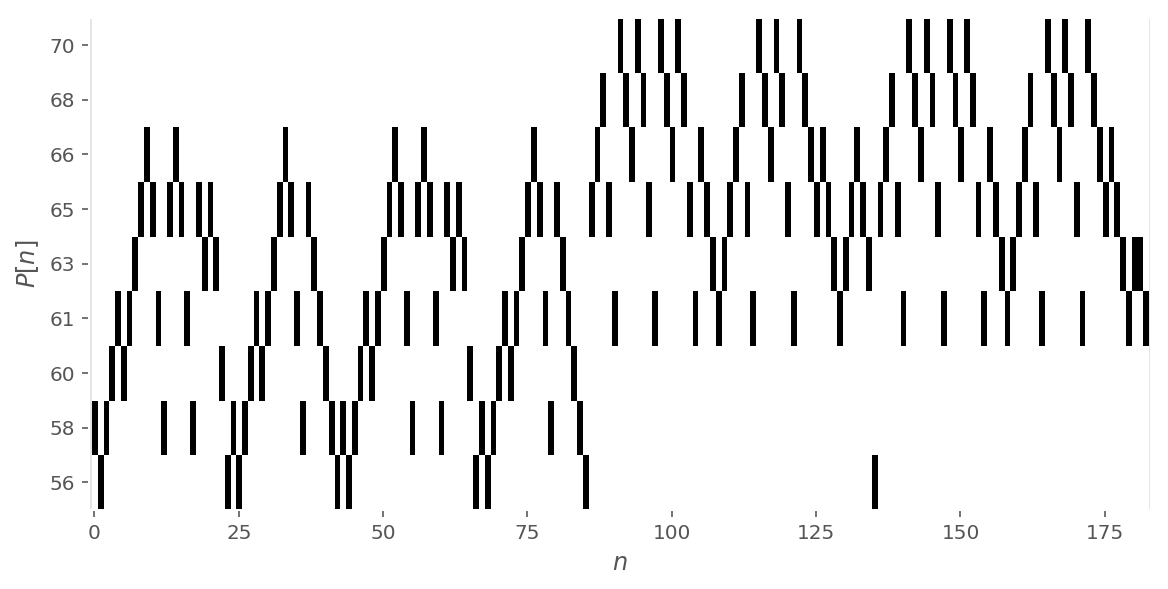

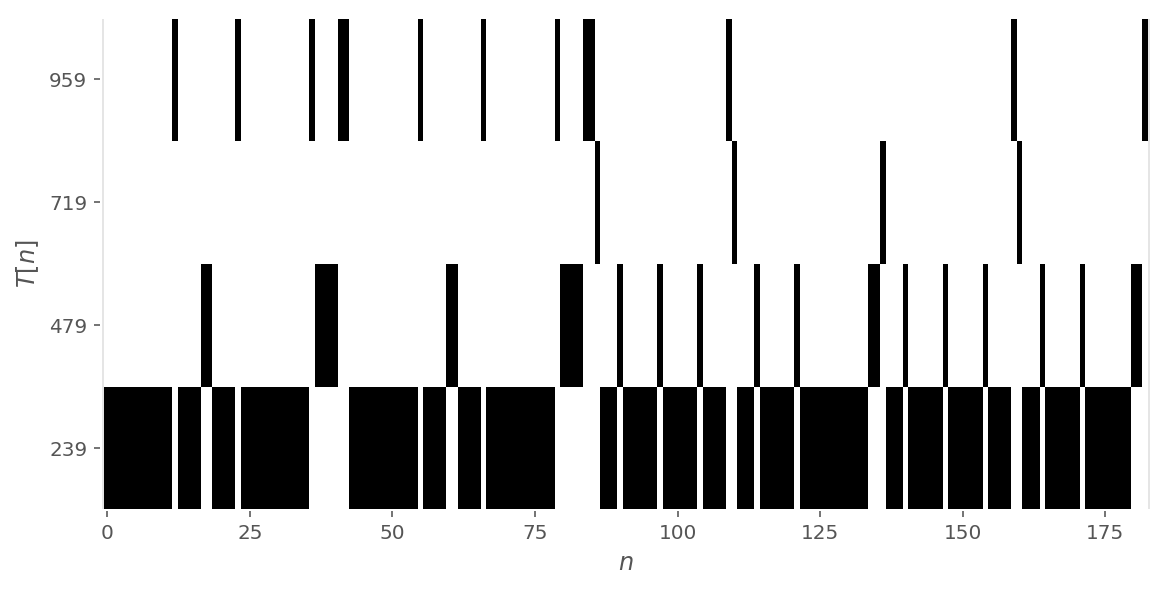

/n
sessiontune290


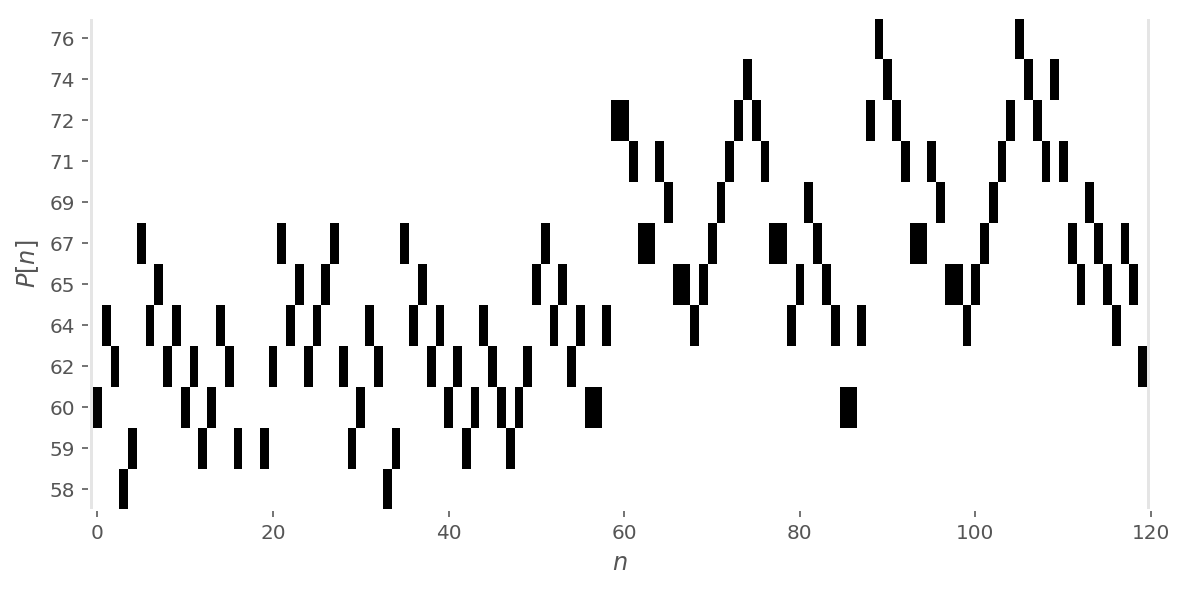

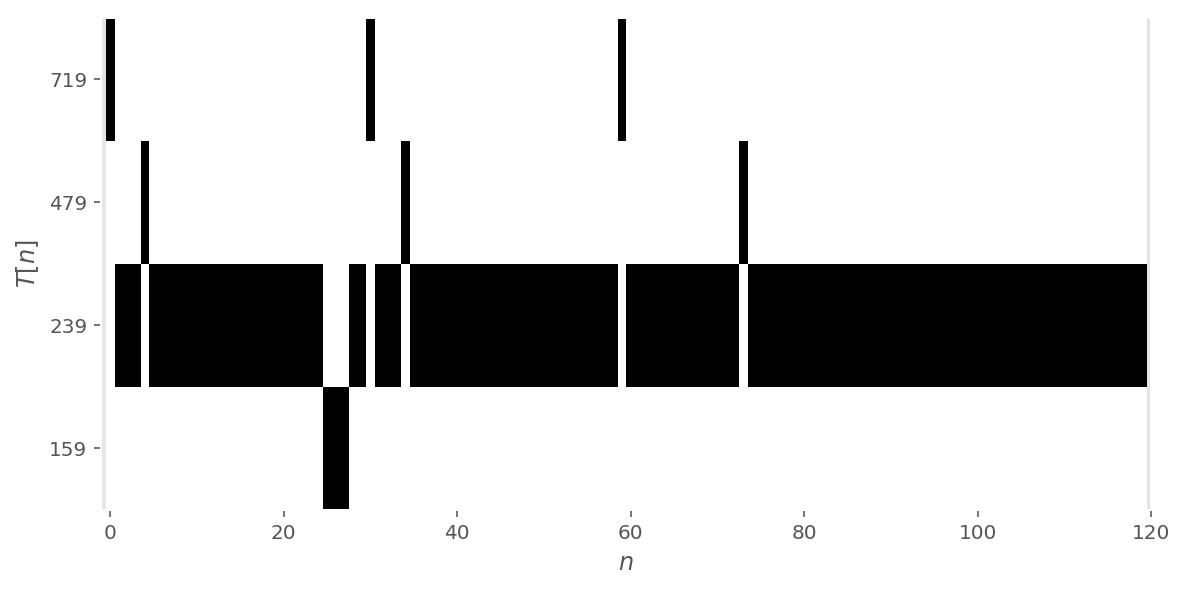

/n


In [344]:
P_dictInv = {v: k for k, v in P_dict.items()}
T_dictInv = {v: k for k, v in T_dict.items()}
dictionaries = {'P': P_dictInv, 'T': T_dictInv}
for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    plotMelody(dataset_translated[label]['P'], dataset_translated[label]['T'], dictionaries)
    print('/n')

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

### Solution

**Rare Event Supression**

In [345]:
from collections import Counter

def get_array(dictionary, attr):
    '''
    Function to get array of values from dict
    '''
    list_ = []
    for value in dictionary.values():
        list_.extend(value[attr])
    return np.asarray(list_)

def build_counter_arrays(array):
    '''
    Function to build and sort counts over an
    array.
    '''
    counter = list(Counter(array).items())
    counter = sorted(counter, key=lambda x: x[0])
    indices = [item[0] for item in counter]
    values = [item[1] for item in counter]
    y_pos = np.arange(len(counter))
    
    return indices, values, y_pos
    
def plot_pitches(dictionary_before, dictionary_after, title):
    '''
    Function tobar plot pitches for the dictionary
    before and after modifiction
    '''
    # 1. gather all pitches in arrays
    P_before = get_array(dictionary_before, 'P')
    P_after = get_array(dictionary_after, 'P')
    
    # 2. build arrays to plot
    indices_b, values_b, y_pos_b = build_counter_arrays(P_before)
    indices_a, values_a, y_pos_a = build_counter_arrays(P_after)
    
    # 2. Plot procedures
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,7))
    fig.suptitle(title)
    # set labels
    ax1.set_xlabel('Pitches'); ax2.set_xlabel('Pitches')
    ax1.set_ylabel('Frequency'); ax2.set_ylabel('Frequency')
    # adjust size
    fig.subplots_adjust(wspace=0.3)
    # plotting...
    ax1.bar(y_pos_b, values_b); ax2.bar(y_pos_a, values_a)
    ax1.set_xticks(y_pos_b); 
    ax2.set_xticks(y_pos_a); 
    

def plot_durations(dictionary):
    '''
    Function to plot melodies' duration histogram
    for the original dataset
    '''
    # 1. gather all durations in a list
    T = get_array(dictionary, 'T')
    
    # 2. build arrays to plot
    indices, values, y_pos = build_counter_arrays(T)
    
    # 3. plot bar
    plt.figure(figsize=(20,7))
    plt.bar(y_pos, values) 
    plt.xticks(y_pos, indices, rotation=90)
    plt.xlabel('Duration')
    plt.ylabel('Occurences')
    plt.title("Melodies' duration occurences")
    plt.grid(True)
    plt.show()
    return Counter(T)

def filter_dataset(dictionary, counter, treshold):
    '''
    Function to filter melodies w/ durations that do not 
    occur very often.
    Iteratively, we filter our dictionary by deleting melodies that
    contain rare durations, until no more melodies can be removed
    because treshold is achieved
    :param counter - dictionary with durations counts
    '''
    # get list ordered by ascending order of occurences
    counter = list(counter.items())
    counter = sorted(counter, key=lambda x: x[1])
    
    # iteratively filters dictionary until treshold
    # is reached
    original_size = len(dictionary)
    for duration_to_remove in counter:
        filtered_dictionary_temp = remove_melodies(dictionary, duration_to_remove[0])  
        if len(filtered_dictionary_temp)/original_size < 1-treshold:
            break  # we have less than (1-treshold)*100% of the dict 
                   # too much filtering was performed. Leave and return
                   # previous dictionary 
        else:
            #print(len(filtered_dictionary_temp)/original_size)
            dictionary = filtered_dictionary_temp # keep filtering
    
    return dictionary

def remove_melodies(dictionary, duration_to_remove):
    '''
    Function that iterates over dataset dictionary
    and deletes melodies containing duration to remove
    '''
    filtered_dictionary = {k: v for k, v in dictionary.items() if duration_to_remove not in dictionary[k]['T']}
    return filtered_dictionary

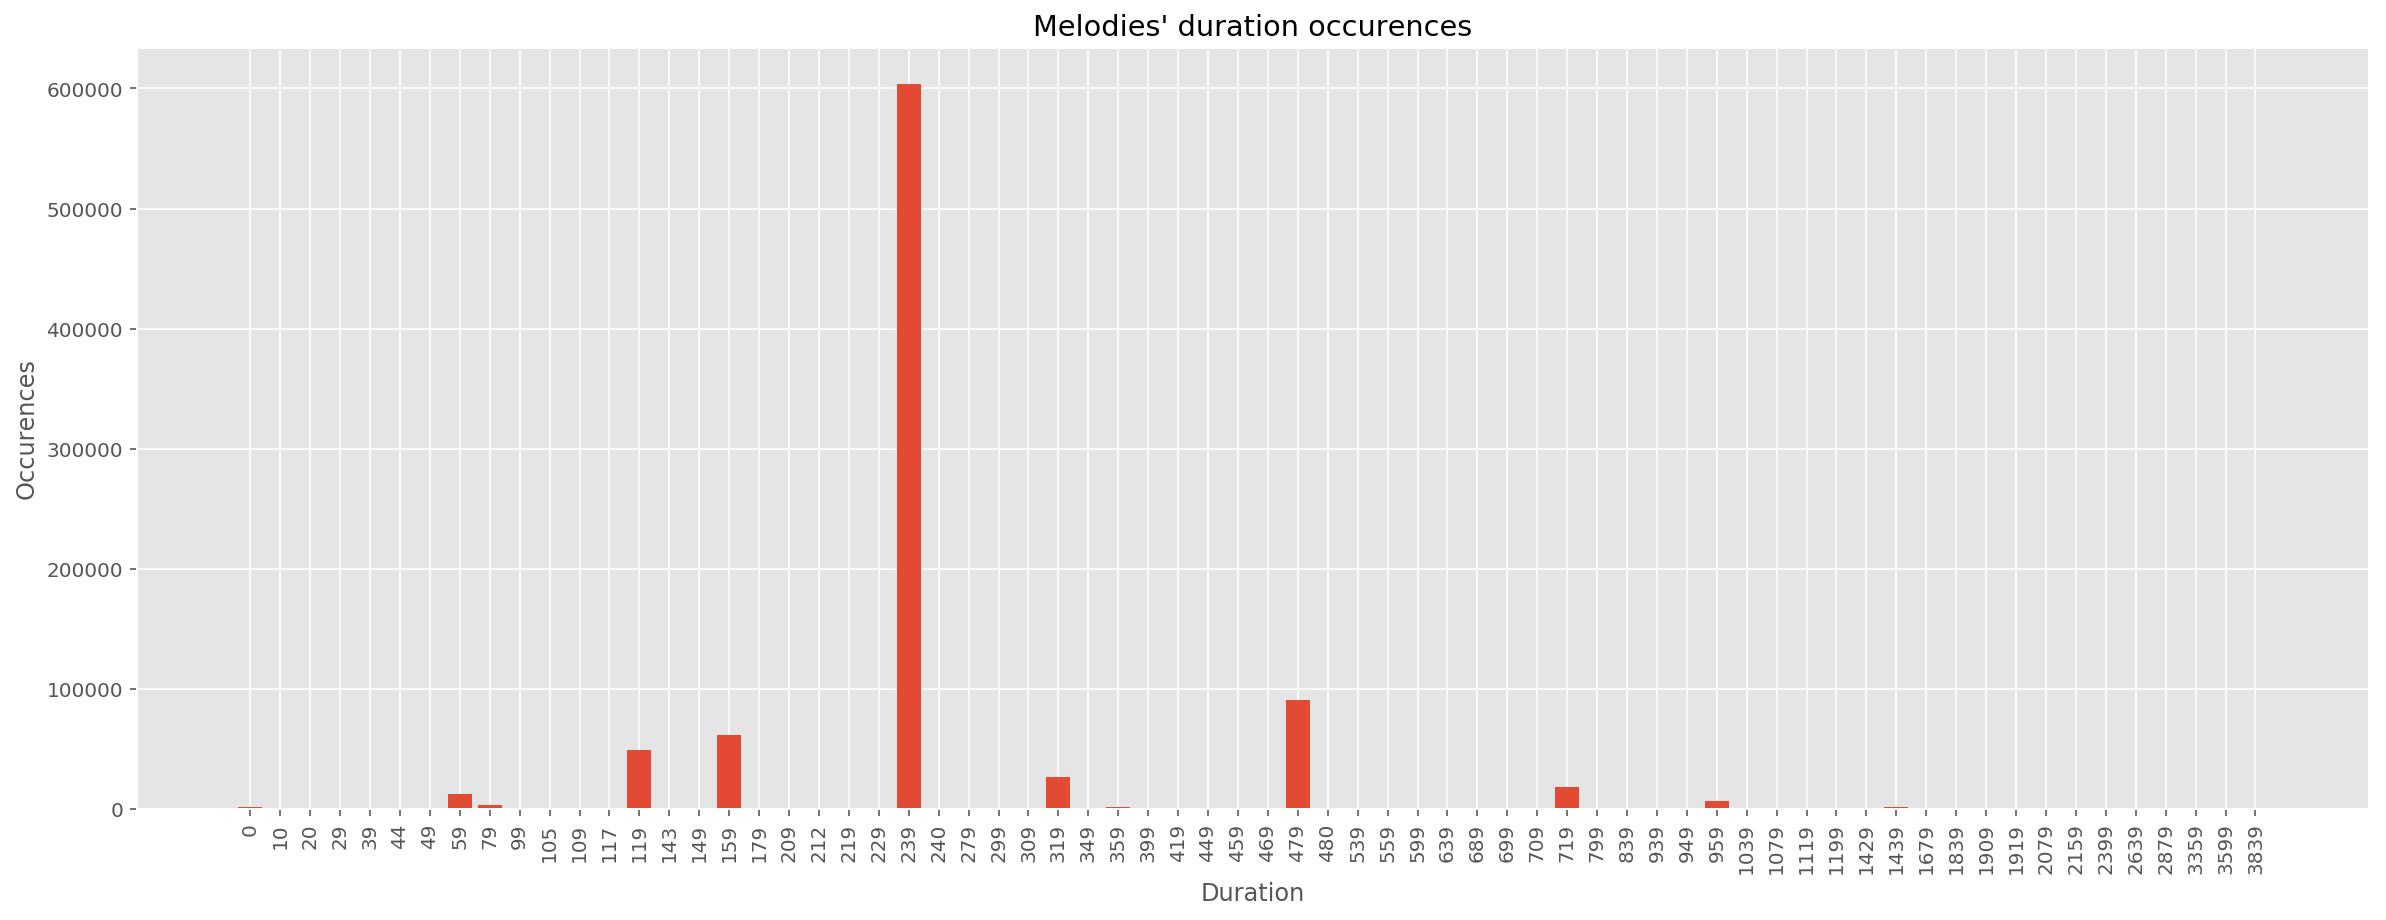

In [346]:
counter = plot_durations(dataset)

Filter dataset for 5% treshold...

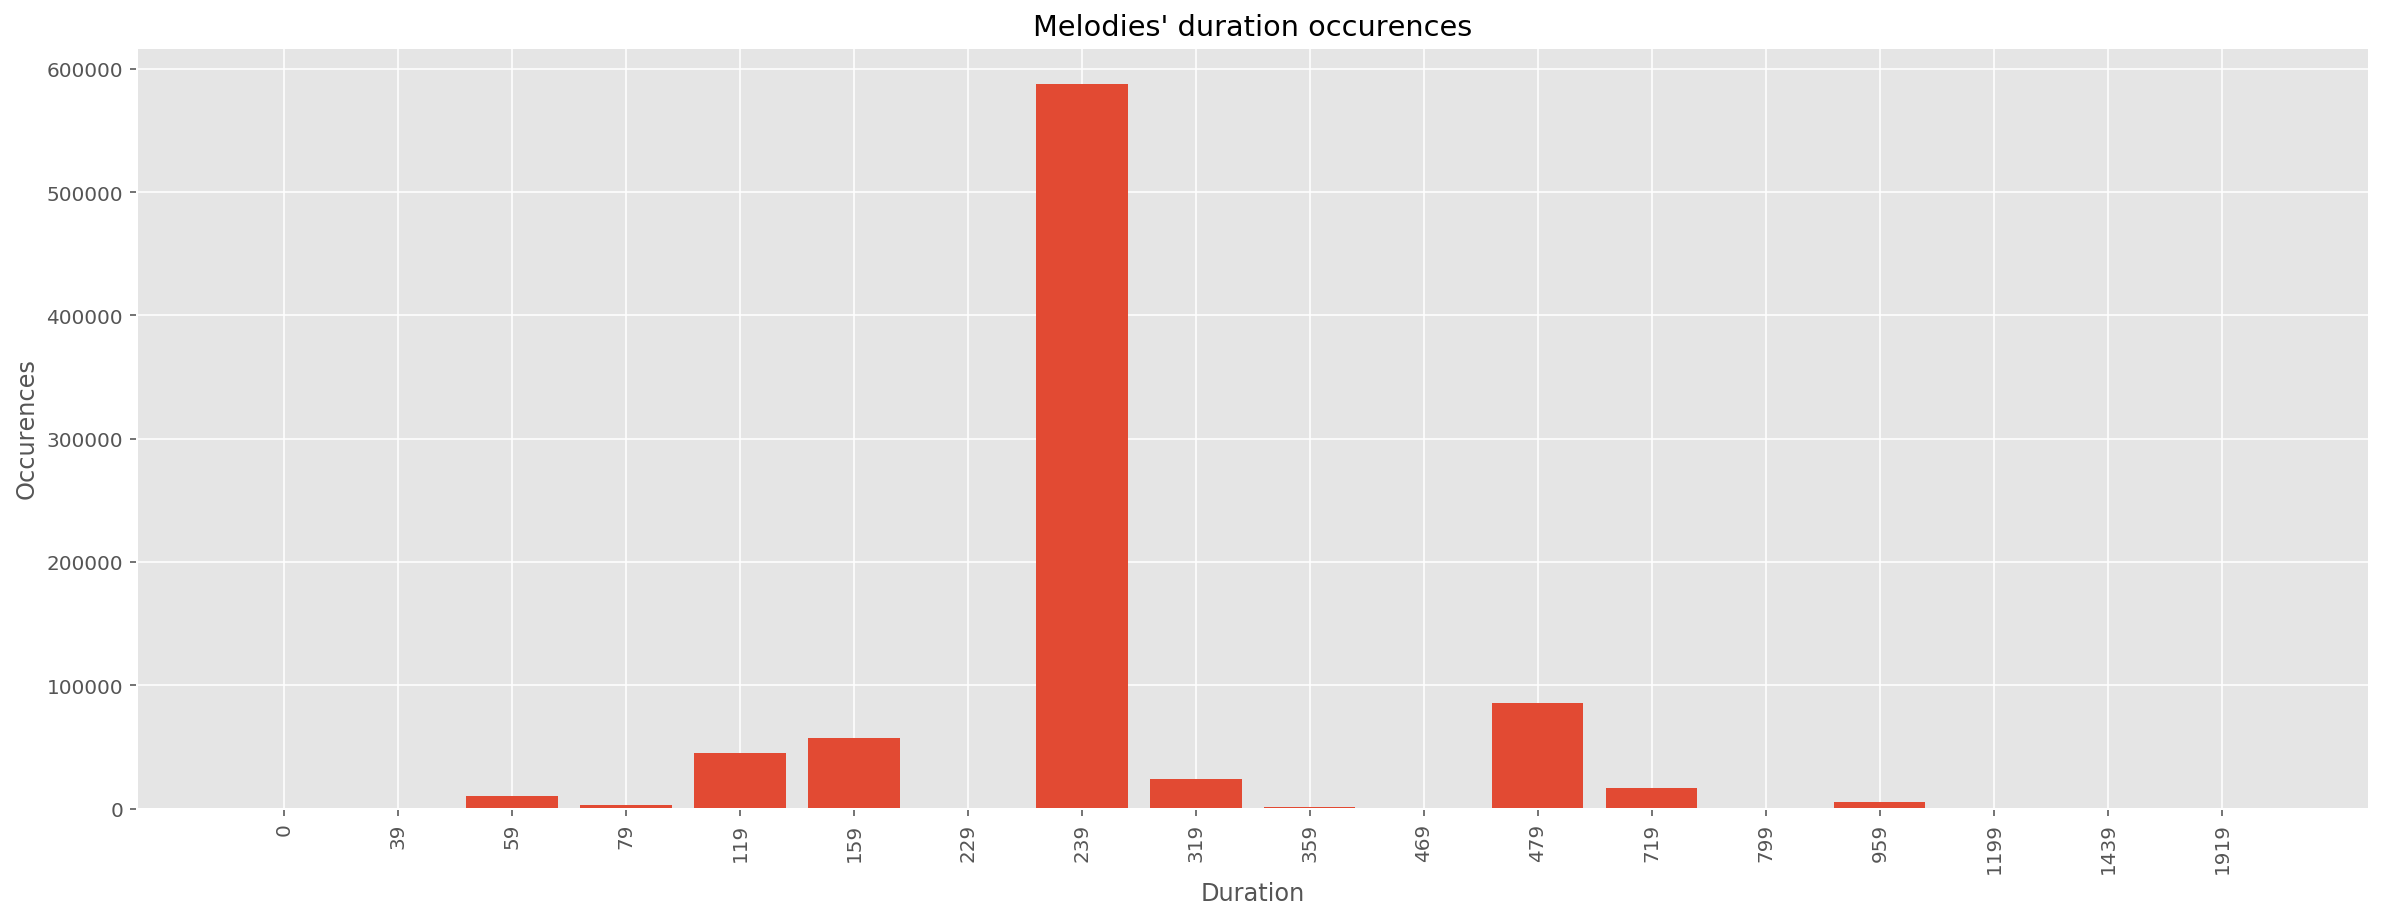

In [347]:
dataset_filtered = filter_dataset(dataset.copy(), counter, 0.05)
counter_filtered = plot_durations(dataset_filtered)

**Transposition variance**:

In [349]:
def transposeDataset(dataset):
    transposed_dataset = {}

    for label in list(dataset.keys()):
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

In [350]:
dataset_transposed = transposeDataset(dataset_filtered)

**Visualize Pitches Histogram**

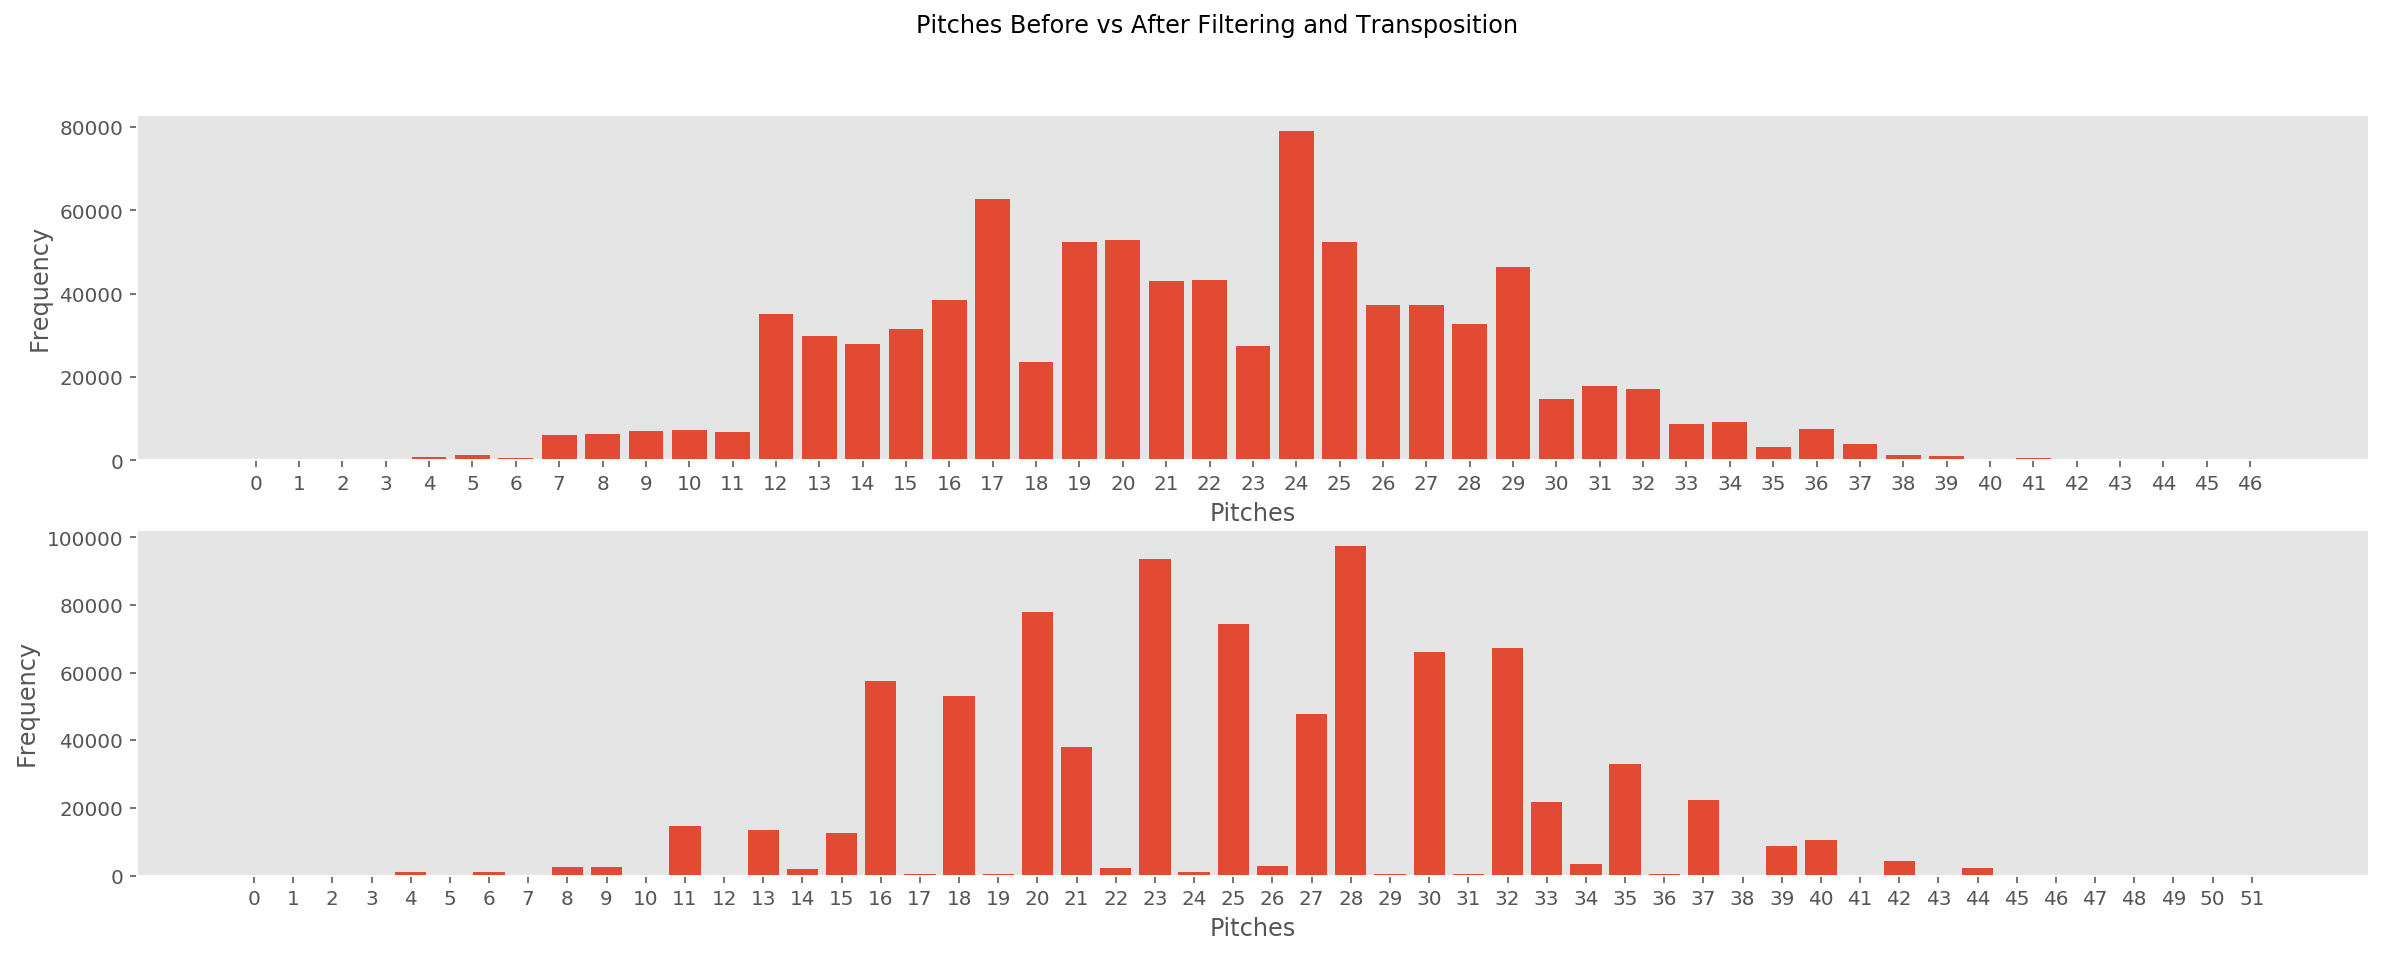

In [351]:
plot_pitches(dataset, dataset_transposed, 'Pitches Before vs After Filtering and Transposition')

**Redo Tokenization and Translation**

In [352]:
# 1) Get list of values
P_values, T_values = get_values(dataset_transposed)

# 2) Translate
dataset_translated_filt, P_dictFilt, T_dictFilt = translate_tracks(dataset_transposed.copy(), P_values, T_values)

# 3) Verify translation
for label in np.random.choice(list(dataset_transposed.keys()), 2):
    if verifier(dataset_transposed, dataset_translated_filt, 'P', P_dictFilt, label) | verifier(dataset_transposed, dataset_translated_filt,'T', T_dictFilt, label):
        print('Correct Translation')

Correct Translation
Correct Translation


**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**: We reduced the space of possible durations in approximately 75%! From 68 possible durations to 18. This obviously impacts the training time, since less data will require less training time. Moreover, by removing outliers from the dataset, we will get a faster convergence of the model.

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**: By transposing all the songs to a single tonality we will get a more robust model that does not deppend on how up shifted a certain melodie is. This is indeed what we are looking for, since this shift does not incur any difference for a human. The model would be equally robust if we represent all the shifted positions for every song, and let the model learn all the scenarios. But this would not be suitable given the size of the generated dataset, since it would take too long to train.

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)? 

**Answer**: If we were to keep the joint of the two dimensions, than we would have to consider 52(#possible pitches) * 18(#possible durations) combinations. This would increase drastically the input size dimension, and consequently the training time.

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: By keeping the two features separated, we can visualize a predominance of certain values. For example, pitches as 23, 25, 28 are very common, such as durations 239 or even 479. Let's pretend we have a joint distribution now. This very common durations, would now be shared with several different pitches. As a consequence, this more common patterns would start fading away. The same thing would happen with the most common pitches, that would now be divided by several different durations they occur with.

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

**One hot encode**

In [354]:
def create_oneHotEncode(dictionary, size_P, size_T):
    '''
    Function to create one hot encoding
    '''
    for key, value in dictionary.items():
        P_onehot = np_utils.to_categorical(value['P'], size_P)
        T_onehot = np_utils.to_categorical(value['T'], size_T)
        dictionary[key] = {"P":P_onehot, "T":T_onehot}
    return dictionary

**Zero Padding**

In [355]:
def get_lists(dictionary):
    '''
    Function to get lists of a dictionary
    '''
    P = []; T = []; lengths = []
    for value in dictionary.values():
        P.append(value['P'])
        T.append(value['T'])
        lengths.append(len((value['P']))) # collect lenght of one hot encoded vector
    return P, T, lengths

def get_sizeParameters(lst):
    '''
    Function to calculate mean size and
    std of a vector containing lengths
    '''
    lst = np.asarray(lst)
    avg = np.mean(lst)
    std = np.std(lst)
    return avg, std

def create_zeroPadding(dictionary):
    '''
    Function to perform zero padding
    Assumes as input a dictionary already
    containing one hot encoded vectors
    '''
    P_padded = []; T_padded = [];
    P_list, T_list, lengths = get_lists(dictionary)
    avg, std = get_sizeParameters(lengths)
    maxlen = int(round(avg + 2*std))
    
    P_padded = pad_sequences(P_list, maxlen=maxlen, padding='post' ,truncating='post', value=0.0)
    T_padded = pad_sequences(T_list, maxlen=maxlen, padding='post' ,truncating='post', value=0.0)
    counter = 0
    for key in dictionary.keys():
        dictionary[key] = {"P":list(P_padded[counter]), "T":list(T_padded[counter])}
        counter = counter + 1
        
    return dictionary, maxlen

In [356]:
dataset_onehot = create_oneHotEncode(dataset_translated_filt.copy(), len(P_dictFilt), len(T_dictFilt))
dataset_padded, song_length = create_zeroPadding(dataset_onehot.copy())

# save in pickle file:
pickle_out = open("dataset_padded.pickle","wb")
pickle.dump(dataset_padded, pickle_out)
pickle_out.close()

Verifying the results:

sessiontune19536 Before


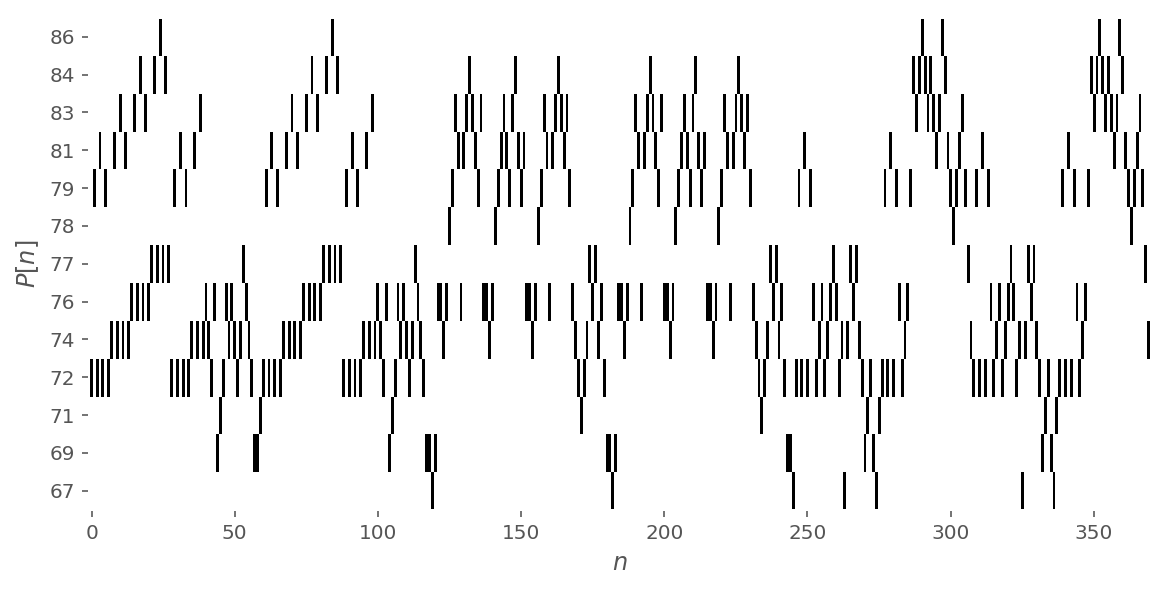

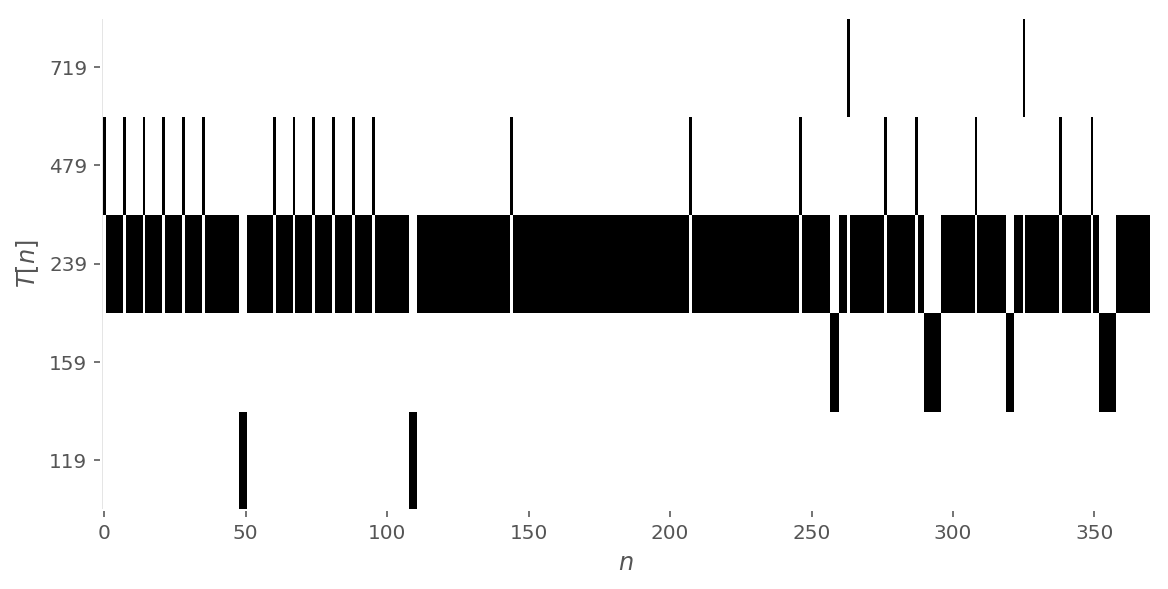

sessiontune19536 After


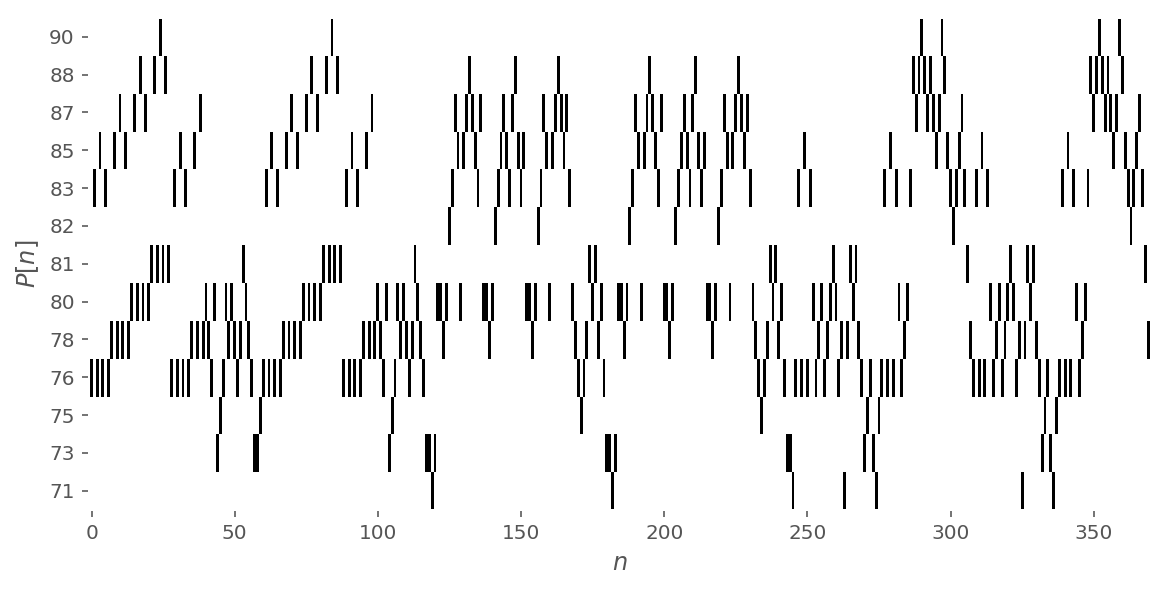

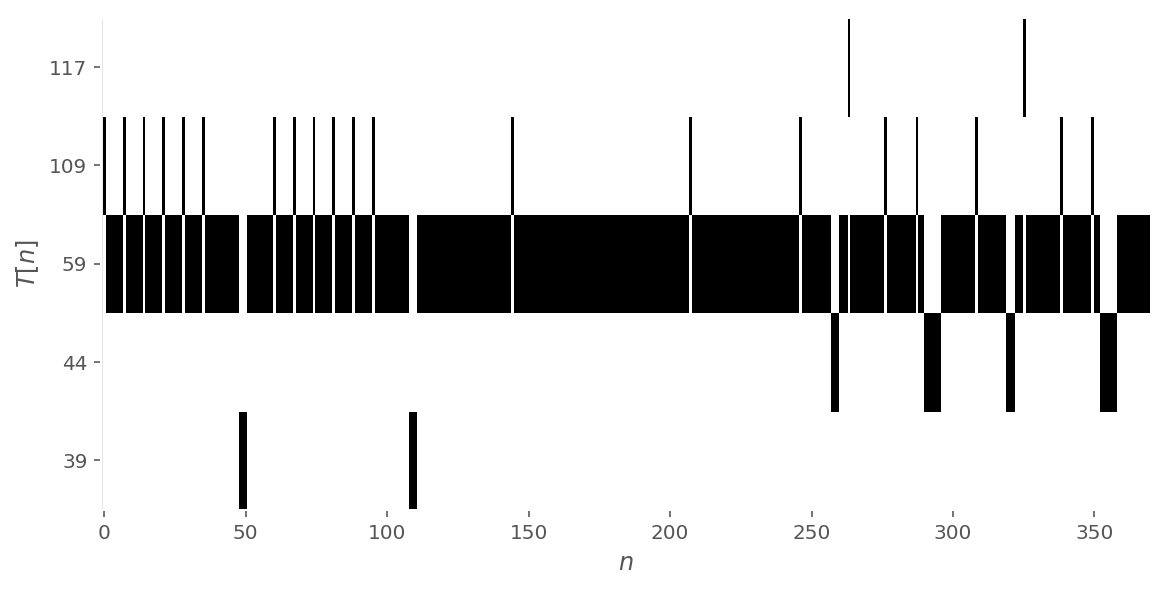

/n
sessiontune23858 Before


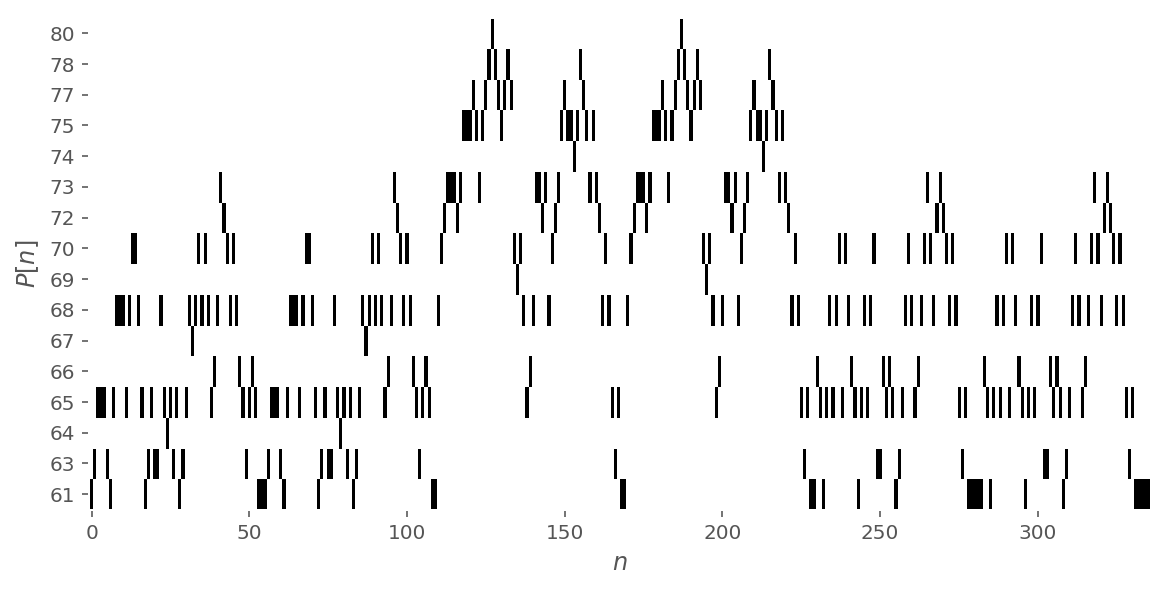

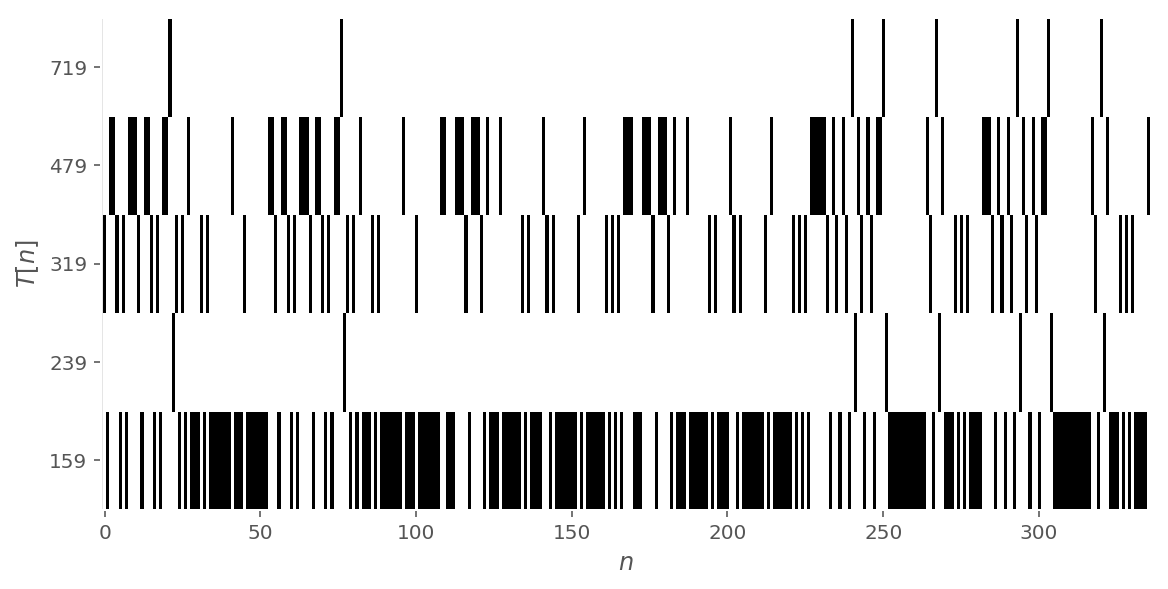

sessiontune23858 After


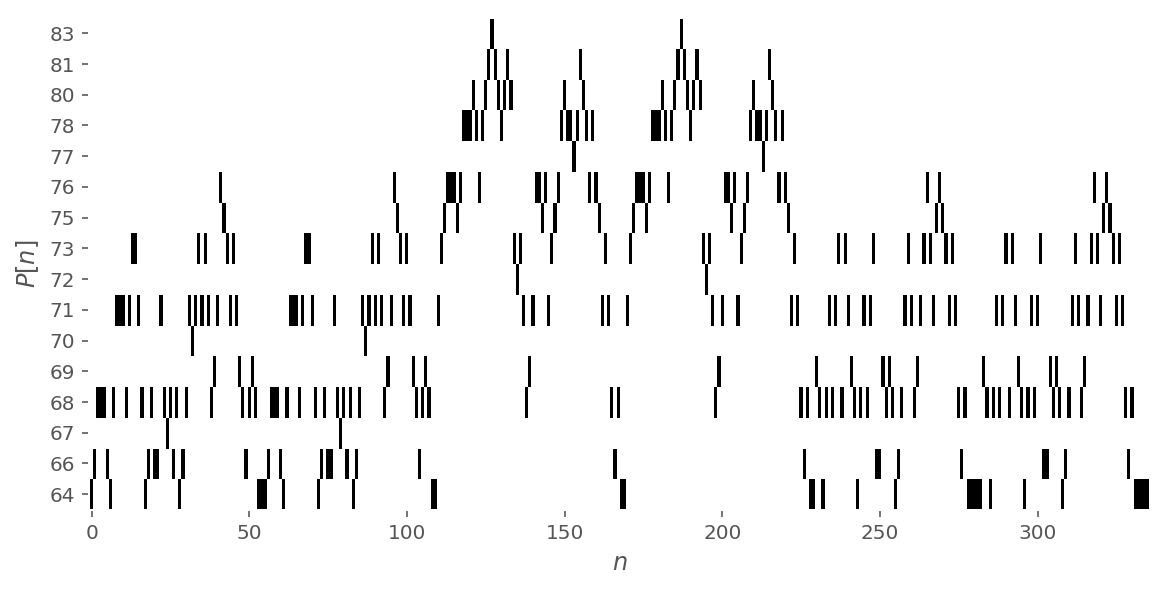

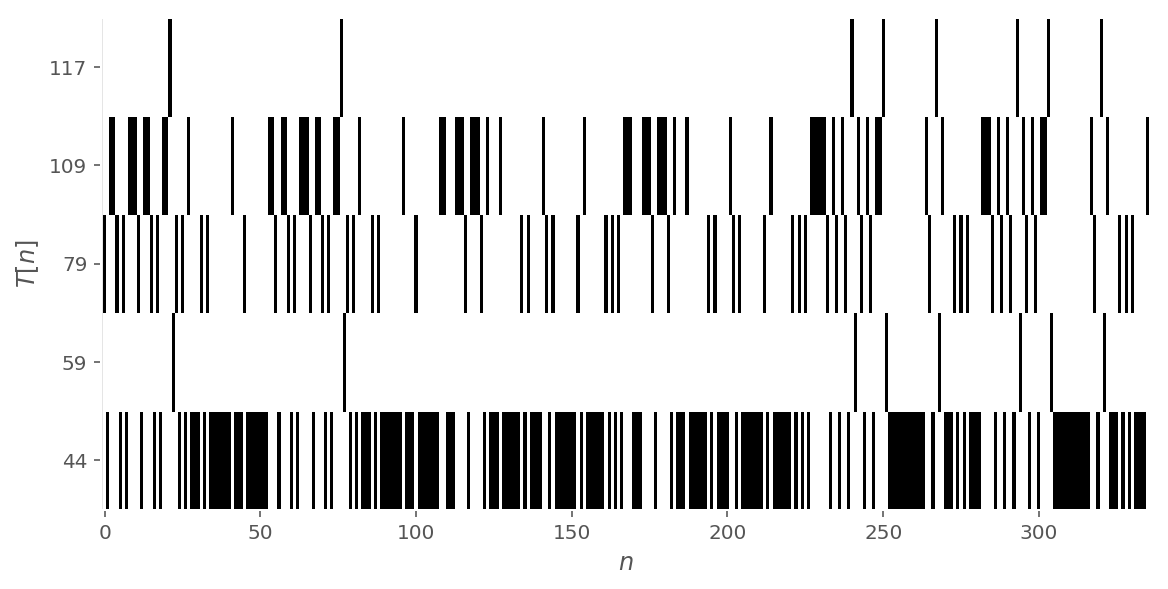

/n


In [357]:
P_dictInvFilt = {v: k for k, v in P_dictFilt.items()}
T_dictInvFilt = {v: k for k, v in T_dictFilt.items()}
dictionariesFilt = {'P': P_dictInvFilt, 'T': T_dictInvFilt}
for label in np.random.choice(list(dataset.keys()), 2):
    print(label, 'Before')
    plotMelody(dataset_translated[label]['P'], dataset_translated[label]['T'], dictionaries)
    print(label, 'After')
    plotMelody(dataset_padded[label]['P'], dataset_padded[label]['T'], dictionaries)
    print('/n')

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [953]:
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    if activation == 'GRU':
        #Your hidden layer(s) architecture with GRU
        H['2'] = GRU(Hsize, dropout=0.2, recurrent_dropout=0.2,
                     implementation=1, return_sequences=True)(H['1'])
    elif activation == 'LSTM':
        #Your hidden layer(s) architecture with LSTM (For your own curiosity, not required for the project)
        H['2'] = LSTM(Hsize,  unit_forget_bias=True, dropout=0.2, recurrent_dropout=0.2,
                      implementation=1, return_sequences=True)(H['1'])
    elif activation == 'RNN':
        #Your hidden layer(s) architecture with SimpleRNN
        H['2'] = SimpleRNN(Hsize, activation='tanh', use_bias=True, dropout=0.2, recurrent_dropout=0.2,
                      return_sequences=True)(H['1'])

    Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H['2'])#Input(s) to duration output layer)
    Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['2'])#Input(s) to pitch output layer)
    
    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])
    model_state = Model(inputs = [X['T'], X['P']], outputs = [H['2']])
    opt = Adam() 
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'])
    
    return model, model_state

def getData(dictionary):
    '''
    Function to get data for building model
    Retrieve results as numpy arrays for convenience
    '''
    x_P = []; x_T = []; # lists to append x data
    y_P = []; y_T = []; # lists to append y data
    for value in dictionary.values():
        x_P.append(value['P'][:-1])
        x_T.append(value['T'][:-1])
        y_P.append(value['P'][1:])
        y_T.append(value['T'][1:])
    return np.asarray(x_P), np.asarray(x_T), np.asarray(y_P), np.asarray(y_T)

def fitModel(model, x, y, verbose = 1, epochs = 250):
    '''
    Function data fits model to given data
    '''
    history = model.fit(x = x, y = y,batch_size=100, epochs=epochs, validation_split = 0.2, verbose=verbose)
    return history

**Getting the data ready...**

In [757]:
XP, XT, YP, YT = getData(dataset_padded)

**Model fitting...**

1.`Simple RNN` model:

In [948]:
RNNmodel, RNNmodel_states = buildModel(dictionariesFilt, 
                      batch_length=song_length-1,#Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      activation='RNN')
RNNmodel.summary()
history_simpleRNN = fitModel(RNNmodel, x=[XT, XP], y = [YT, YP])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 380, 18)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 380, 52)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 380, 18)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 380, 52)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

Epoch 24/250
3516/3516 [==============================] - 35s 10ms/step - loss: 2.7609 - YT_loss: 0.7449 - YP_loss: 2.0160 - YT_acc: 0.7856 - YP_acc: 0.2970 - val_loss: 2.5866 - val_YT_loss: 0.6795 - val_YP_loss: 1.9070 - val_YT_acc: 0.8041 - val_YP_acc: 0.3310
Epoch 25/250
3516/3516 [==============================] - 32s 9ms/step - loss: 2.7700 - YT_loss: 0.7586 - YP_loss: 2.0114 - YT_acc: 0.7833 - YP_acc: 0.2969 - val_loss: 2.5824 - val_YT_loss: 0.6783 - val_YP_loss: 1.9041 - val_YT_acc: 0.8042 - val_YP_acc: 0.3353
Epoch 26/250
3516/3516 [==============================] - 33s 9ms/step - loss: 2.7603 - YT_loss: 0.7492 - YP_loss: 2.0110 - YT_acc: 0.7856 - YP_acc: 0.2972 - val_loss: 2.5856 - val_YT_loss: 0.6809 - val_YP_loss: 1.9047 - val_YT_acc: 0.8024 - val_YP_acc: 0.3331
Epoch 27/250
3516/3516 [==============================] - 35s 10ms/step - loss: 2.7587 - YT_loss: 0.7497 - YP_loss: 2.0089 - YT_acc: 0.7857 - YP_acc: 0.2981 - val_loss: 2.5767 - val_YT_loss: 0.6761 - val_YP_loss: 1.9

3516/3516 [==============================] - 35s 10ms/step - loss: 2.6880 - YT_loss: 0.7247 - YP_loss: 1.9633 - YT_acc: 0.7901 - YP_acc: 0.3120 - val_loss: 2.5116 - val_YT_loss: 0.6514 - val_YP_loss: 1.8601 - val_YT_acc: 0.8129 - val_YP_acc: 0.3476
Epoch 56/250
3516/3516 [==============================] - 33s 9ms/step - loss: 2.6759 - YT_loss: 0.7137 - YP_loss: 1.9622 - YT_acc: 0.7921 - YP_acc: 0.3126 - val_loss: 2.5051 - val_YT_loss: 0.6487 - val_YP_loss: 1.8563 - val_YT_acc: 0.8128 - val_YP_acc: 0.3507
Epoch 57/250
3516/3516 [==============================] - 33s 9ms/step - loss: 2.6750 - YT_loss: 0.7123 - YP_loss: 1.9627 - YT_acc: 0.7927 - YP_acc: 0.3135 - val_loss: 2.5124 - val_YT_loss: 0.6497 - val_YP_loss: 1.8627 - val_YT_acc: 0.8111 - val_YP_acc: 0.3465
Epoch 58/250
3516/3516 [==============================] - 33s 9ms/step - loss: 2.6786 - YT_loss: 0.7165 - YP_loss: 1.9621 - YT_acc: 0.7919 - YP_acc: 0.3141 - val_loss: 2.5007 - val_YT_loss: 0.6465 - val_YP_loss: 1.8542 - val_YT_a

3516/3516 [==============================] - 34s 10ms/step - loss: 2.6262 - YT_loss: 0.6902 - YP_loss: 1.9360 - YT_acc: 0.7954 - YP_acc: 0.3224 - val_loss: 2.4532 - val_YT_loss: 0.6234 - val_YP_loss: 1.8298 - val_YT_acc: 0.8153 - val_YP_acc: 0.3584
Epoch 87/250
3516/3516 [==============================] - 33s 9ms/step - loss: 2.6217 - YT_loss: 0.6889 - YP_loss: 1.9329 - YT_acc: 0.7965 - YP_acc: 0.3251 - val_loss: 2.4478 - val_YT_loss: 0.6208 - val_YP_loss: 1.8270 - val_YT_acc: 0.8153 - val_YP_acc: 0.3613
Epoch 88/250
3516/3516 [==============================] - 34s 10ms/step - loss: 2.6275 - YT_loss: 0.6967 - YP_loss: 1.9308 - YT_acc: 0.7950 - YP_acc: 0.3238 - val_loss: 2.4519 - val_YT_loss: 0.6232 - val_YP_loss: 1.8287 - val_YT_acc: 0.8143 - val_YP_acc: 0.3576
Epoch 89/250
3516/3516 [==============================] - 34s 10ms/step - loss: 2.6275 - YT_loss: 0.6923 - YP_loss: 1.9352 - YT_acc: 0.7960 - YP_acc: 0.3225 - val_loss: 2.4493 - val_YT_loss: 0.6234 - val_YP_loss: 1.8260 - val_YT

3516/3516 [==============================] - 33s 10ms/step - loss: 2.5976 - YT_loss: 0.6826 - YP_loss: 1.9150 - YT_acc: 0.7977 - YP_acc: 0.3305 - val_loss: 2.4179 - val_YT_loss: 0.6075 - val_YP_loss: 1.8104 - val_YT_acc: 0.8170 - val_YP_acc: 0.3661
Epoch 118/250
3516/3516 [==============================] - 35s 10ms/step - loss: 2.6007 - YT_loss: 0.6783 - YP_loss: 1.9223 - YT_acc: 0.8001 - YP_acc: 0.3277 - val_loss: 2.4236 - val_YT_loss: 0.6136 - val_YP_loss: 1.8099 - val_YT_acc: 0.8157 - val_YP_acc: 0.3657
Epoch 119/250
3516/3516 [==============================] - 35s 10ms/step - loss: 2.6083 - YT_loss: 0.6893 - YP_loss: 1.9190 - YT_acc: 0.7956 - YP_acc: 0.3290 - val_loss: 2.4155 - val_YT_loss: 0.6073 - val_YP_loss: 1.8082 - val_YT_acc: 0.8168 - val_YP_acc: 0.3666
Epoch 120/250
3516/3516 [==============================] - 37s 11ms/step - loss: 2.5969 - YT_loss: 0.6823 - YP_loss: 1.9147 - YT_acc: 0.7981 - YP_acc: 0.3299 - val_loss: 2.4141 - val_YT_loss: 0.6075 - val_YP_loss: 1.8065 - va

3516/3516 [==============================] - 33s 9ms/step - loss: 2.5831 - YT_loss: 0.6773 - YP_loss: 1.9058 - YT_acc: 0.7985 - YP_acc: 0.3330 - val_loss: 2.3954 - val_YT_loss: 0.6037 - val_YP_loss: 1.7917 - val_YT_acc: 0.8168 - val_YP_acc: 0.3715
Epoch 149/250
3516/3516 [==============================] - 38s 11ms/step - loss: 2.5908 - YT_loss: 0.6825 - YP_loss: 1.9083 - YT_acc: 0.7971 - YP_acc: 0.3317 - val_loss: 2.3969 - val_YT_loss: 0.6039 - val_YP_loss: 1.7929 - val_YT_acc: 0.8175 - val_YP_acc: 0.3711
Epoch 150/250
3516/3516 [==============================] - 33s 9ms/step - loss: 2.5739 - YT_loss: 0.6723 - YP_loss: 1.9016 - YT_acc: 0.7990 - YP_acc: 0.3335 - val_loss: 2.4043 - val_YT_loss: 0.6099 - val_YP_loss: 1.7943 - val_YT_acc: 0.8170 - val_YP_acc: 0.3709
Epoch 151/250
3516/3516 [==============================] - 37s 10ms/step - loss: 2.5755 - YT_loss: 0.6721 - YP_loss: 1.9034 - YT_acc: 0.7996 - YP_acc: 0.3337 - val_loss: 2.3927 - val_YT_loss: 0.6027 - val_YP_loss: 1.7901 - val_

3516/3516 [==============================] - 38s 11ms/step - loss: 2.5894 - YT_loss: 0.6763 - YP_loss: 1.9131 - YT_acc: 0.7997 - YP_acc: 0.3311 - val_loss: 2.3968 - val_YT_loss: 0.5997 - val_YP_loss: 1.7971 - val_YT_acc: 0.8187 - val_YP_acc: 0.3703
Epoch 180/250
3516/3516 [==============================] - 35s 10ms/step - loss: 2.5919 - YT_loss: 0.6812 - YP_loss: 1.9106 - YT_acc: 0.7985 - YP_acc: 0.3320 - val_loss: 2.3977 - val_YT_loss: 0.6008 - val_YP_loss: 1.7970 - val_YT_acc: 0.8181 - val_YP_acc: 0.3718
Epoch 181/250
3516/3516 [==============================] - 35s 10ms/step - loss: 2.5815 - YT_loss: 0.6713 - YP_loss: 1.9102 - YT_acc: 0.8011 - YP_acc: 0.3299 - val_loss: 2.3965 - val_YT_loss: 0.6004 - val_YP_loss: 1.7961 - val_YT_acc: 0.8178 - val_YP_acc: 0.3713
Epoch 182/250
3516/3516 [==============================] - 34s 10ms/step - loss: 2.5826 - YT_loss: 0.6725 - YP_loss: 1.9101 - YT_acc: 0.8002 - YP_acc: 0.3303 - val_loss: 2.3940 - val_YT_loss: 0.5991 - val_YP_loss: 1.7949 - va

3516/3516 [==============================] - 34s 10ms/step - loss: 2.5613 - YT_loss: 0.6702 - YP_loss: 1.8912 - YT_acc: 0.8000 - YP_acc: 0.3367 - val_loss: 2.3699 - val_YT_loss: 0.5914 - val_YP_loss: 1.7785 - val_YT_acc: 0.8199 - val_YP_acc: 0.3763
Epoch 211/250
3516/3516 [==============================] - 34s 10ms/step - loss: 2.5673 - YT_loss: 0.6695 - YP_loss: 1.8978 - YT_acc: 0.8015 - YP_acc: 0.3364 - val_loss: 2.4206 - val_YT_loss: 0.6146 - val_YP_loss: 1.8060 - val_YT_acc: 0.8162 - val_YP_acc: 0.3690
Epoch 212/250
3516/3516 [==============================] - 34s 10ms/step - loss: 2.6015 - YT_loss: 0.6867 - YP_loss: 1.9147 - YT_acc: 0.7984 - YP_acc: 0.3291 - val_loss: 2.3979 - val_YT_loss: 0.6039 - val_YP_loss: 1.7940 - val_YT_acc: 0.8184 - val_YP_acc: 0.3716
Epoch 213/250
3516/3516 [==============================] - 38s 11ms/step - loss: 2.5788 - YT_loss: 0.6762 - YP_loss: 1.9025 - YT_acc: 0.8003 - YP_acc: 0.3322 - val_loss: 2.3857 - val_YT_loss: 0.5984 - val_YP_loss: 1.7874 - va

3516/3516 [==============================] - 33s 9ms/step - loss: 2.5617 - YT_loss: 0.6736 - YP_loss: 1.8881 - YT_acc: 0.7992 - YP_acc: 0.3375 - val_loss: 2.3549 - val_YT_loss: 0.5878 - val_YP_loss: 1.7671 - val_YT_acc: 0.8206 - val_YP_acc: 0.3806
Epoch 242/250
3516/3516 [==============================] - 34s 10ms/step - loss: 2.5482 - YT_loss: 0.6640 - YP_loss: 1.8842 - YT_acc: 0.8018 - YP_acc: 0.3390 - val_loss: 2.3557 - val_YT_loss: 0.5894 - val_YP_loss: 1.7663 - val_YT_acc: 0.8207 - val_YP_acc: 0.3804
Epoch 243/250
3516/3516 [==============================] - 33s 9ms/step - loss: 2.5569 - YT_loss: 0.6732 - YP_loss: 1.8837 - YT_acc: 0.7999 - YP_acc: 0.3392 - val_loss: 2.3555 - val_YT_loss: 0.5879 - val_YP_loss: 1.7676 - val_YT_acc: 0.8205 - val_YP_acc: 0.3800
Epoch 244/250
3516/3516 [==============================] - 33s 9ms/step - loss: 2.5462 - YT_loss: 0.6640 - YP_loss: 1.8821 - YT_acc: 0.8008 - YP_acc: 0.3387 - val_loss: 2.3533 - val_YT_loss: 0.5889 - val_YP_loss: 1.7643 - val_Y

Summary plot:

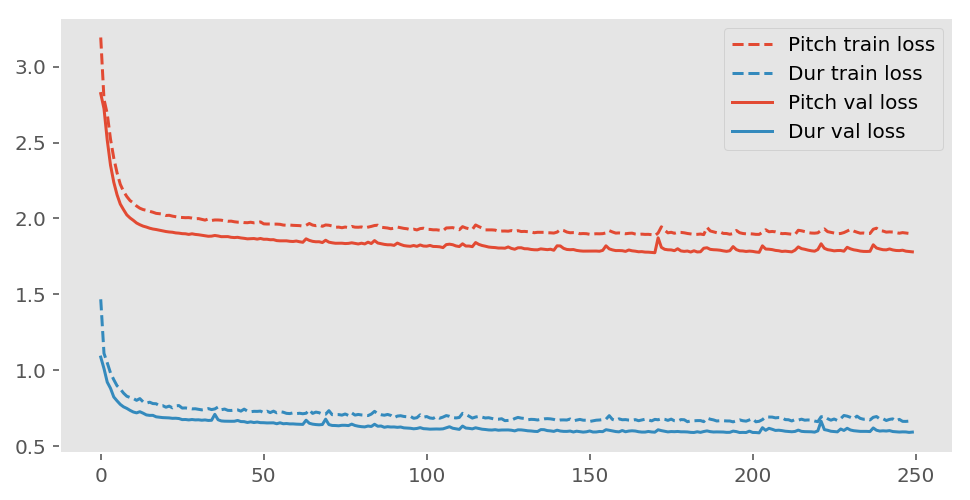

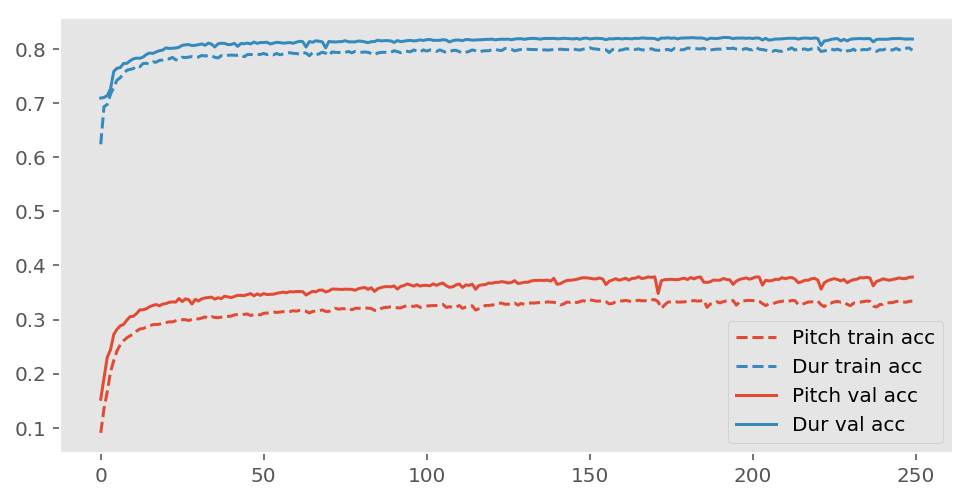

In [373]:
plotLearningCurves(history_simpleRNN)

2.`GRU` model:

In [949]:
GRUmodel, GRUmodel_states = buildModel(dictionariesFilt, 
                      batch_length=song_length-1,
                      activation='GRU')
GRUmodel.summary()
history_GRU = fitModel(GRUmodel, x=[XT, XP], y = [YT, YP])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 380, 18)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 380, 52)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 380, 18)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 380, 52)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

Epoch 24/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.5977 - YT_loss: 0.6830 - YP_loss: 1.9147 - YT_acc: 0.7919 - YP_acc: 0.3265 - val_loss: 2.4913 - val_YT_loss: 0.6429 - val_YP_loss: 1.8484 - val_YT_acc: 0.8051 - val_YP_acc: 0.3517
Epoch 25/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.5889 - YT_loss: 0.6800 - YP_loss: 1.9089 - YT_acc: 0.7928 - YP_acc: 0.3297 - val_loss: 2.4839 - val_YT_loss: 0.6390 - val_YP_loss: 1.8449 - val_YT_acc: 0.8062 - val_YP_acc: 0.3527
Epoch 26/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.5805 - YT_loss: 0.6756 - YP_loss: 1.9049 - YT_acc: 0.7942 - YP_acc: 0.3301 - val_loss: 2.4751 - val_YT_loss: 0.6360 - val_YP_loss: 1.8391 - val_YT_acc: 0.8064 - val_YP_acc: 0.3561
Epoch 27/250
3516/3516 [==============================] - 48s 14ms/step - loss: 2.5688 - YT_loss: 0.6713 - YP_loss: 1.8975 - YT_acc: 0.7956 - YP_acc: 0.3336 - val_loss: 2.4714 - val_YT_loss: 0.6355 - val_YP_loss: 1

3516/3516 [==============================] - 51s 14ms/step - loss: 2.4256 - YT_loss: 0.6181 - YP_loss: 1.8075 - YT_acc: 0.8087 - YP_acc: 0.3637 - val_loss: 2.3365 - val_YT_loss: 0.5888 - val_YP_loss: 1.7477 - val_YT_acc: 0.8182 - val_YP_acc: 0.3832
Epoch 56/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.4198 - YT_loss: 0.6165 - YP_loss: 1.8032 - YT_acc: 0.8102 - YP_acc: 0.3658 - val_loss: 2.3341 - val_YT_loss: 0.5876 - val_YP_loss: 1.7464 - val_YT_acc: 0.8184 - val_YP_acc: 0.3836
Epoch 57/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.4159 - YT_loss: 0.6161 - YP_loss: 1.7998 - YT_acc: 0.8103 - YP_acc: 0.3661 - val_loss: 2.3303 - val_YT_loss: 0.5866 - val_YP_loss: 1.7437 - val_YT_acc: 0.8181 - val_YP_acc: 0.3850
Epoch 58/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.4175 - YT_loss: 0.6171 - YP_loss: 1.8004 - YT_acc: 0.8084 - YP_acc: 0.3663 - val_loss: 2.3276 - val_YT_loss: 0.5860 - val_YP_loss: 1.7416 - val_Y

3516/3516 [==============================] - 56s 16ms/step - loss: 2.3223 - YT_loss: 0.5758 - YP_loss: 1.7465 - YT_acc: 0.8174 - YP_acc: 0.3843 - val_loss: 2.2302 - val_YT_loss: 0.5429 - val_YP_loss: 1.6873 - val_YT_acc: 0.8239 - val_YP_acc: 0.4046
Epoch 87/250
3516/3516 [==============================] - 59s 17ms/step - loss: 2.3230 - YT_loss: 0.5752 - YP_loss: 1.7477 - YT_acc: 0.8181 - YP_acc: 0.3833 - val_loss: 2.2281 - val_YT_loss: 0.5416 - val_YP_loss: 1.6866 - val_YT_acc: 0.8242 - val_YP_acc: 0.4044
Epoch 88/250
3516/3516 [==============================] - 55s 16ms/step - loss: 2.3149 - YT_loss: 0.5716 - YP_loss: 1.7432 - YT_acc: 0.8173 - YP_acc: 0.3859 - val_loss: 2.2235 - val_YT_loss: 0.5405 - val_YP_loss: 1.6830 - val_YT_acc: 0.8244 - val_YP_acc: 0.4058
Epoch 89/250
3516/3516 [==============================] - 52s 15ms/step - loss: 2.3164 - YT_loss: 0.5726 - YP_loss: 1.7439 - YT_acc: 0.8183 - YP_acc: 0.3861 - val_loss: 2.2265 - val_YT_loss: 0.5417 - val_YP_loss: 1.6848 - val_Y

3516/3516 [==============================] - 49s 14ms/step - loss: 2.2517 - YT_loss: 0.5451 - YP_loss: 1.7065 - YT_acc: 0.8220 - YP_acc: 0.3977 - val_loss: 2.1565 - val_YT_loss: 0.5117 - val_YP_loss: 1.6448 - val_YT_acc: 0.8282 - val_YP_acc: 0.4206
Epoch 118/250
3516/3516 [==============================] - 50s 14ms/step - loss: 2.2481 - YT_loss: 0.5444 - YP_loss: 1.7037 - YT_acc: 0.8224 - YP_acc: 0.3984 - val_loss: 2.1565 - val_YT_loss: 0.5128 - val_YP_loss: 1.6437 - val_YT_acc: 0.8279 - val_YP_acc: 0.4211
Epoch 119/250
3516/3516 [==============================] - 51s 15ms/step - loss: 2.2505 - YT_loss: 0.5437 - YP_loss: 1.7069 - YT_acc: 0.8226 - YP_acc: 0.3982 - val_loss: 2.1535 - val_YT_loss: 0.5110 - val_YP_loss: 1.6425 - val_YT_acc: 0.8279 - val_YP_acc: 0.4224
Epoch 120/250
3516/3516 [==============================] - 51s 14ms/step - loss: 2.2501 - YT_loss: 0.5427 - YP_loss: 1.7075 - YT_acc: 0.8220 - YP_acc: 0.3974 - val_loss: 2.1512 - val_YT_loss: 0.5093 - val_YP_loss: 1.6420 - va

3516/3516 [==============================] - 52s 15ms/step - loss: 2.2090 - YT_loss: 0.5268 - YP_loss: 1.6822 - YT_acc: 0.8247 - YP_acc: 0.4063 - val_loss: 2.1153 - val_YT_loss: 0.4998 - val_YP_loss: 1.6155 - val_YT_acc: 0.8289 - val_YP_acc: 0.4333
Epoch 149/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.2043 - YT_loss: 0.5274 - YP_loss: 1.6769 - YT_acc: 0.8248 - YP_acc: 0.4081 - val_loss: 2.1126 - val_YT_loss: 0.4994 - val_YP_loss: 1.6132 - val_YT_acc: 0.8294 - val_YP_acc: 0.4339
Epoch 150/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.2050 - YT_loss: 0.5281 - YP_loss: 1.6770 - YT_acc: 0.8240 - YP_acc: 0.4092 - val_loss: 2.1114 - val_YT_loss: 0.4994 - val_YP_loss: 1.6120 - val_YT_acc: 0.8292 - val_YP_acc: 0.4345
Epoch 151/250
3516/3516 [==============================] - 48s 14ms/step - loss: 2.2016 - YT_loss: 0.5244 - YP_loss: 1.6772 - YT_acc: 0.8251 - YP_acc: 0.4079 - val_loss: 2.1128 - val_YT_loss: 0.4998 - val_YP_loss: 1.6130 - va

3516/3516 [==============================] - 49s 14ms/step - loss: 2.1757 - YT_loss: 0.5180 - YP_loss: 1.6577 - YT_acc: 0.8266 - YP_acc: 0.4155 - val_loss: 2.0921 - val_YT_loss: 0.4949 - val_YP_loss: 1.5972 - val_YT_acc: 0.8295 - val_YP_acc: 0.4401
Epoch 180/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.1739 - YT_loss: 0.5171 - YP_loss: 1.6568 - YT_acc: 0.8266 - YP_acc: 0.4164 - val_loss: 2.0885 - val_YT_loss: 0.4937 - val_YP_loss: 1.5948 - val_YT_acc: 0.8296 - val_YP_acc: 0.4420
Epoch 181/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.1799 - YT_loss: 0.5211 - YP_loss: 1.6588 - YT_acc: 0.8254 - YP_acc: 0.4150 - val_loss: 2.0969 - val_YT_loss: 0.4979 - val_YP_loss: 1.5989 - val_YT_acc: 0.8295 - val_YP_acc: 0.4385
Epoch 182/250
3516/3516 [==============================] - 50s 14ms/step - loss: 2.1790 - YT_loss: 0.5187 - YP_loss: 1.6603 - YT_acc: 0.8252 - YP_acc: 0.4153 - val_loss: 2.0918 - val_YT_loss: 0.4948 - val_YP_loss: 1.5970 - va

3516/3516 [==============================] - 51s 15ms/step - loss: 2.1496 - YT_loss: 0.5082 - YP_loss: 1.6415 - YT_acc: 0.8271 - YP_acc: 0.4208 - val_loss: 2.0747 - val_YT_loss: 0.4915 - val_YP_loss: 1.5831 - val_YT_acc: 0.8308 - val_YP_acc: 0.4459
Epoch 211/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.1508 - YT_loss: 0.5104 - YP_loss: 1.6405 - YT_acc: 0.8270 - YP_acc: 0.4201 - val_loss: 2.0742 - val_YT_loss: 0.4907 - val_YP_loss: 1.5835 - val_YT_acc: 0.8303 - val_YP_acc: 0.4451
Epoch 212/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.1498 - YT_loss: 0.5131 - YP_loss: 1.6367 - YT_acc: 0.8266 - YP_acc: 0.4221 - val_loss: 2.0739 - val_YT_loss: 0.4909 - val_YP_loss: 1.5831 - val_YT_acc: 0.8304 - val_YP_acc: 0.4456
Epoch 213/250
3516/3516 [==============================] - 48s 14ms/step - loss: 2.1544 - YT_loss: 0.5113 - YP_loss: 1.6431 - YT_acc: 0.8263 - YP_acc: 0.4213 - val_loss: 2.0743 - val_YT_loss: 0.4911 - val_YP_loss: 1.5832 - va

3516/3516 [==============================] - 8285s 2s/step - loss: 2.1421 - YT_loss: 0.5071 - YP_loss: 1.6350 - YT_acc: 0.8279 - YP_acc: 0.4233 - val_loss: 2.0692 - val_YT_loss: 0.4906 - val_YP_loss: 1.5786 - val_YT_acc: 0.8303 - val_YP_acc: 0.4467
Epoch 242/250
3516/3516 [==============================] - 67s 19ms/step - loss: 2.1373 - YT_loss: 0.5072 - YP_loss: 1.6301 - YT_acc: 0.8275 - YP_acc: 0.4242 - val_loss: 2.0654 - val_YT_loss: 0.4889 - val_YP_loss: 1.5765 - val_YT_acc: 0.8311 - val_YP_acc: 0.4480
Epoch 243/250
3516/3516 [==============================] - 51s 15ms/step - loss: 2.1358 - YT_loss: 0.5063 - YP_loss: 1.6296 - YT_acc: 0.8288 - YP_acc: 0.4252 - val_loss: 2.0652 - val_YT_loss: 0.4897 - val_YP_loss: 1.5755 - val_YT_acc: 0.8306 - val_YP_acc: 0.4482
Epoch 244/250
3516/3516 [==============================] - 49s 14ms/step - loss: 2.1340 - YT_loss: 0.5061 - YP_loss: 1.6279 - YT_acc: 0.8278 - YP_acc: 0.4258 - val_loss: 2.0622 - val_YT_loss: 0.4891 - val_YP_loss: 1.5731 - va

3.`LSTM` model:

In [954]:
LSTMmodel, LSTMmodel_states = buildModel(dictionariesFilt, 
                      batch_length=song_length-1,
                      activation='LSTM')
LSTMmodel.summary()
history_LSTM = fitModel(LSTMmodel, x=[XT, XP], y = [YT, YP])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 380, 18)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 380, 52)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 380, 18)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 380, 52)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

Epoch 24/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.6165 - YT_loss: 0.6843 - YP_loss: 1.9322 - YT_acc: 0.7902 - YP_acc: 0.3234 - val_loss: 2.5591 - val_YT_loss: 0.6629 - val_YP_loss: 1.8962 - val_YT_acc: 0.7958 - val_YP_acc: 0.3371
Epoch 25/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.6080 - YT_loss: 0.6829 - YP_loss: 1.9252 - YT_acc: 0.7902 - YP_acc: 0.3253 - val_loss: 2.5495 - val_YT_loss: 0.6612 - val_YP_loss: 1.8883 - val_YT_acc: 0.7954 - val_YP_acc: 0.3398
Epoch 26/250
3516/3516 [==============================] - 54s 15ms/step - loss: 2.5997 - YT_loss: 0.6788 - YP_loss: 1.9209 - YT_acc: 0.7916 - YP_acc: 0.3265 - val_loss: 2.5416 - val_YT_loss: 0.6592 - val_YP_loss: 1.8824 - val_YT_acc: 0.7967 - val_YP_acc: 0.3437
Epoch 27/250
3516/3516 [==============================] - 54s 15ms/step - loss: 2.5890 - YT_loss: 0.6741 - YP_loss: 1.9150 - YT_acc: 0.7942 - YP_acc: 0.3287 - val_loss: 2.5310 - val_YT_loss: 0.6538 - val_YP_loss: 1

3516/3516 [==============================] - 53s 15ms/step - loss: 2.4295 - YT_loss: 0.6177 - YP_loss: 1.8118 - YT_acc: 0.8084 - YP_acc: 0.3625 - val_loss: 2.3718 - val_YT_loss: 0.5988 - val_YP_loss: 1.7729 - val_YT_acc: 0.8166 - val_YP_acc: 0.3752
Epoch 56/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.4237 - YT_loss: 0.6165 - YP_loss: 1.8072 - YT_acc: 0.8086 - YP_acc: 0.3644 - val_loss: 2.3687 - val_YT_loss: 0.5979 - val_YP_loss: 1.7708 - val_YT_acc: 0.8166 - val_YP_acc: 0.3754
Epoch 57/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.4195 - YT_loss: 0.6156 - YP_loss: 1.8039 - YT_acc: 0.8093 - YP_acc: 0.3643 - val_loss: 2.3667 - val_YT_loss: 0.5974 - val_YP_loss: 1.7693 - val_YT_acc: 0.8174 - val_YP_acc: 0.3762
Epoch 58/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.4169 - YT_loss: 0.6143 - YP_loss: 1.8025 - YT_acc: 0.8091 - YP_acc: 0.3660 - val_loss: 2.3634 - val_YT_loss: 0.5957 - val_YP_loss: 1.7676 - val_Y

3516/3516 [==============================] - 53s 15ms/step - loss: 2.3396 - YT_loss: 0.5918 - YP_loss: 1.7478 - YT_acc: 0.8138 - YP_acc: 0.3828 - val_loss: 2.2921 - val_YT_loss: 0.5741 - val_YP_loss: 1.7180 - val_YT_acc: 0.8207 - val_YP_acc: 0.3926
Epoch 87/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.3384 - YT_loss: 0.5919 - YP_loss: 1.7464 - YT_acc: 0.8138 - YP_acc: 0.3834 - val_loss: 2.2908 - val_YT_loss: 0.5747 - val_YP_loss: 1.7161 - val_YT_acc: 0.8201 - val_YP_acc: 0.3924
Epoch 88/250
3516/3516 [==============================] - 54s 15ms/step - loss: 2.3382 - YT_loss: 0.5910 - YP_loss: 1.7471 - YT_acc: 0.8147 - YP_acc: 0.3842 - val_loss: 2.2896 - val_YT_loss: 0.5744 - val_YP_loss: 1.7152 - val_YT_acc: 0.8205 - val_YP_acc: 0.3944
Epoch 89/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.3324 - YT_loss: 0.5879 - YP_loss: 1.7445 - YT_acc: 0.8150 - YP_acc: 0.3856 - val_loss: 2.2845 - val_YT_loss: 0.5729 - val_YP_loss: 1.7116 - val_Y

3516/3516 [==============================] - 53s 15ms/step - loss: 2.2780 - YT_loss: 0.5736 - YP_loss: 1.7044 - YT_acc: 0.8186 - YP_acc: 0.3978 - val_loss: 2.2335 - val_YT_loss: 0.5569 - val_YP_loss: 1.6766 - val_YT_acc: 0.8237 - val_YP_acc: 0.4076
Epoch 118/250
3516/3516 [==============================] - 54s 15ms/step - loss: 2.2748 - YT_loss: 0.5713 - YP_loss: 1.7036 - YT_acc: 0.8192 - YP_acc: 0.3988 - val_loss: 2.2292 - val_YT_loss: 0.5554 - val_YP_loss: 1.6739 - val_YT_acc: 0.8240 - val_YP_acc: 0.4082
Epoch 119/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.2732 - YT_loss: 0.5709 - YP_loss: 1.7023 - YT_acc: 0.8193 - YP_acc: 0.3986 - val_loss: 2.2296 - val_YT_loss: 0.5554 - val_YP_loss: 1.6742 - val_YT_acc: 0.8239 - val_YP_acc: 0.4075
Epoch 120/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.2734 - YT_loss: 0.5711 - YP_loss: 1.7023 - YT_acc: 0.8189 - YP_acc: 0.3994 - val_loss: 2.2274 - val_YT_loss: 0.5552 - val_YP_loss: 1.6722 - va

3516/3516 [==============================] - 53s 15ms/step - loss: 2.2141 - YT_loss: 0.5432 - YP_loss: 1.6709 - YT_acc: 0.8232 - YP_acc: 0.4104 - val_loss: 2.1629 - val_YT_loss: 0.5201 - val_YP_loss: 1.6427 - val_YT_acc: 0.8279 - val_YP_acc: 0.4188
Epoch 149/250
3516/3516 [==============================] - 54s 15ms/step - loss: 2.2129 - YT_loss: 0.5414 - YP_loss: 1.6715 - YT_acc: 0.8236 - YP_acc: 0.4096 - val_loss: 2.1601 - val_YT_loss: 0.5196 - val_YP_loss: 1.6405 - val_YT_acc: 0.8282 - val_YP_acc: 0.4211
Epoch 150/250
3516/3516 [==============================] - 54s 15ms/step - loss: 2.2118 - YT_loss: 0.5414 - YP_loss: 1.6705 - YT_acc: 0.8240 - YP_acc: 0.4095 - val_loss: 2.1578 - val_YT_loss: 0.5183 - val_YP_loss: 1.6395 - val_YT_acc: 0.8283 - val_YP_acc: 0.4209
Epoch 151/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.2087 - YT_loss: 0.5412 - YP_loss: 1.6675 - YT_acc: 0.8237 - YP_acc: 0.4107 - val_loss: 2.1559 - val_YT_loss: 0.5172 - val_YP_loss: 1.6386 - va

3516/3516 [==============================] - 53s 15ms/step - loss: 2.1660 - YT_loss: 0.5232 - YP_loss: 1.6428 - YT_acc: 0.8273 - YP_acc: 0.4205 - val_loss: 2.1163 - val_YT_loss: 0.5038 - val_YP_loss: 1.6125 - val_YT_acc: 0.8311 - val_YP_acc: 0.4303
Epoch 180/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.1654 - YT_loss: 0.5228 - YP_loss: 1.6425 - YT_acc: 0.8266 - YP_acc: 0.4201 - val_loss: 2.1180 - val_YT_loss: 0.5049 - val_YP_loss: 1.6131 - val_YT_acc: 0.8309 - val_YP_acc: 0.4305
Epoch 181/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.1614 - YT_loss: 0.5228 - YP_loss: 1.6386 - YT_acc: 0.8271 - YP_acc: 0.4205 - val_loss: 2.1158 - val_YT_loss: 0.5035 - val_YP_loss: 1.6123 - val_YT_acc: 0.8310 - val_YP_acc: 0.4308
Epoch 182/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.1588 - YT_loss: 0.5213 - YP_loss: 1.6375 - YT_acc: 0.8272 - YP_acc: 0.4212 - val_loss: 2.1139 - val_YT_loss: 0.5043 - val_YP_loss: 1.6096 - va

3516/3516 [==============================] - 53s 15ms/step - loss: 2.1518 - YT_loss: 0.5184 - YP_loss: 1.6335 - YT_acc: 0.8281 - YP_acc: 0.4228 - val_loss: 2.0942 - val_YT_loss: 0.4974 - val_YP_loss: 1.5968 - val_YT_acc: 0.8321 - val_YP_acc: 0.4363
Epoch 211/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.1360 - YT_loss: 0.5129 - YP_loss: 1.6231 - YT_acc: 0.8276 - YP_acc: 0.4266 - val_loss: 2.0849 - val_YT_loss: 0.4947 - val_YP_loss: 1.5902 - val_YT_acc: 0.8321 - val_YP_acc: 0.4394
Epoch 212/250
3516/3516 [==============================] - 54s 15ms/step - loss: 2.1279 - YT_loss: 0.5094 - YP_loss: 1.6185 - YT_acc: 0.8290 - YP_acc: 0.4280 - val_loss: 2.0863 - val_YT_loss: 0.4947 - val_YP_loss: 1.5916 - val_YT_acc: 0.8319 - val_YP_acc: 0.4385
Epoch 213/250
3516/3516 [==============================] - 55s 16ms/step - loss: 2.1275 - YT_loss: 0.5098 - YP_loss: 1.6177 - YT_acc: 0.8286 - YP_acc: 0.4281 - val_loss: 2.0819 - val_YT_loss: 0.4943 - val_YP_loss: 1.5876 - va

3516/3516 [==============================] - 54s 15ms/step - loss: 2.1007 - YT_loss: 0.5008 - YP_loss: 1.5999 - YT_acc: 0.8298 - YP_acc: 0.4350 - val_loss: 2.0613 - val_YT_loss: 0.4889 - val_YP_loss: 1.5725 - val_YT_acc: 0.8328 - val_YP_acc: 0.4464
Epoch 242/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.0974 - YT_loss: 0.4990 - YP_loss: 1.5984 - YT_acc: 0.8303 - YP_acc: 0.4360 - val_loss: 2.0596 - val_YT_loss: 0.4885 - val_YP_loss: 1.5711 - val_YT_acc: 0.8325 - val_YP_acc: 0.4469
Epoch 243/250
3516/3516 [==============================] - 53s 15ms/step - loss: 2.0965 - YT_loss: 0.5005 - YP_loss: 1.5961 - YT_acc: 0.8296 - YP_acc: 0.4357 - val_loss: 2.0597 - val_YT_loss: 0.4894 - val_YP_loss: 1.5703 - val_YT_acc: 0.8324 - val_YP_acc: 0.4476
Epoch 244/250
3516/3516 [==============================] - 57s 16ms/step - loss: 2.0985 - YT_loss: 0.5003 - YP_loss: 1.5982 - YT_acc: 0.8297 - YP_acc: 0.4347 - val_loss: 2.0595 - val_YT_loss: 0.4885 - val_YP_loss: 1.5710 - va

**Plotting Comparison...**

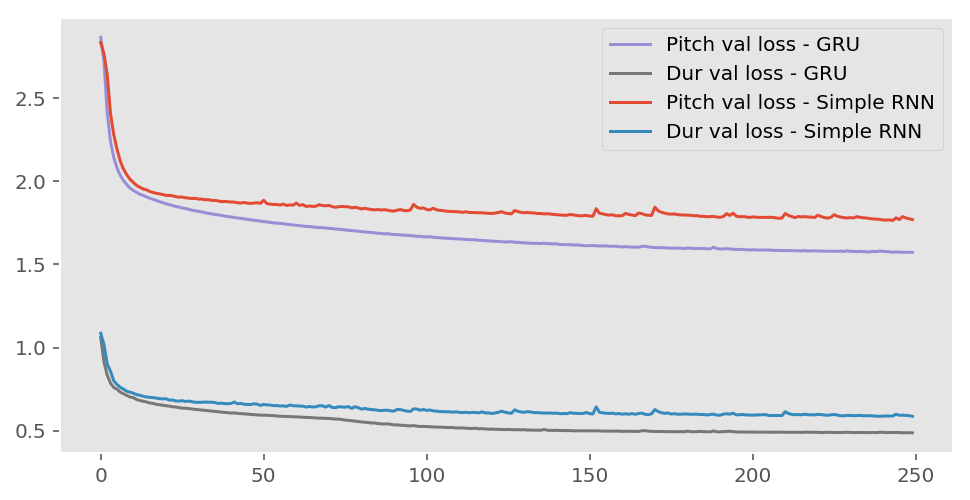

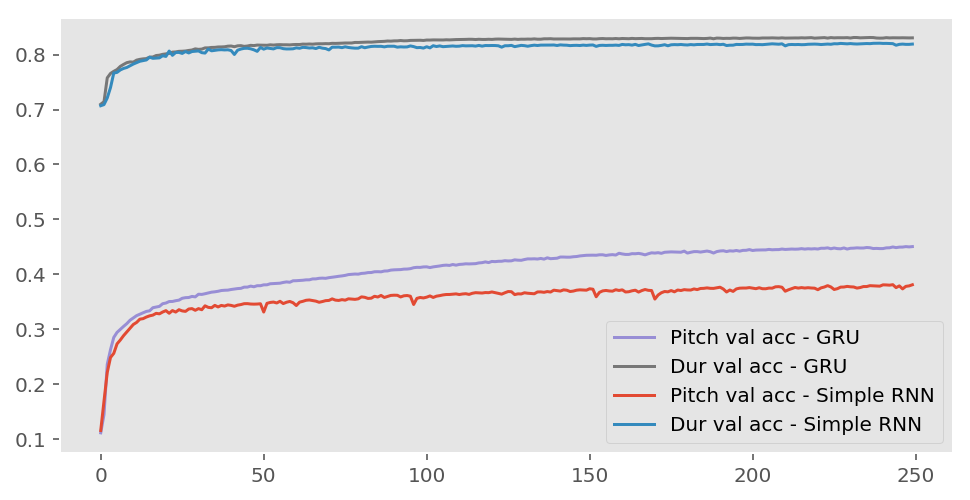

In [950]:
plotLearningCurves(history_simpleRNN, history_GRU, comparisonMode=True)

**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: 

|            | Pitch Accuracy  | Duration Accuracy |
|------------|-----------------|-------------------|
| Simple RNN | 0.3808          | 0.8194            |
| GRU        | 0.4503          | 0.8308            |
| LSTM       | 0.4483          | 0.8322            |

The best accuracy for the Pitch Durations was obtained with the `GRU` model, whereas the best duration accuracy as otained with the `LSTM` model.

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**: To begin with, we would expect a better performance from the GRU model, given its capability of keeping long lasting relations with previous steps. Moreover, we observed already its higher performance in the accuracy table. 
Indeed, we observe that the GRU model gets a better accuracy and smaller loss as the number of epochs increase, compared with the Simple RNN model.
Furthermore, from the figures above, we can say that the simple RNN model tends to converge faster, whereas the GRU's accuracy seems to keep rising, even after 200 epochs.

## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

**1. Model Output visualization **

In [816]:
def getPredictionData(XP, XT, YP, YT, melodie):
    '''
    Function to reshape data for the right format
    to be predicted.
    '''
    x_T = np.reshape(XT[melodie],(1,XT[melodie].shape[0],XT[melodie].shape[1]))
    x_P = np.reshape(XP[melodie],(1,XP[melodie].shape[0],XP[melodie].shape[1]))
    y_T = np.reshape(YT[melodie],(1,YT[melodie].shape[0],YT[melodie].shape[1]))
    y_P = np.reshape(YP[melodie],(1,YP[melodie].shape[0],YP[melodie].shape[1]))
    
    return x_T, x_P, y_T, y_P

def modelOutput(model, model_states, XP, XT, YP, YT, hidden_states = False): 
    '''
    This function plots the output of out model.
    There are two modes:
    - hidden states = False : plots the melodies
    - hidden states = True : plots the melodies + hiddent states
    '''

    for melodie_i in range(4):
        melodie = random.randint(0, XP.shape[0]) 
        # Data
        x_T, x_P, y_T, y_P = getPredictionData(XP, XT, YP, YT, melodie)
        
        # Predicting
        print('Predicting song {}...'.format(melodie_i+1))
        predicted_T, predicted_P = model.predict(x = [x_T, x_P], batch_size=50)
        metrics = model.evaluate(x=[x_T, x_P], y=[y_T, y_P], batch_size=50, verbose=0)
        print('Prediction performance: \n{}:\n{}'.format(model.metrics_names, metrics))
        
        # Hidden states
        if hidden_states == True:
            H = model_states.predict(x = [x_T, x_P], batch_size=50)[0]
            print(H.shape)
        else:
            H = None 
            
        # Plot results-  NOTE: we select index[0] which corresponds
        # to the first row (and only row) for solving dimension compability issues
        # between the function to PlotMelodies and model.predict
        plotMelody(pitches[0], durations[0], dictionariesFilt, PrP=predicted_P[0], PrT=predicted_T[0], H = H)

Predicting song 1...
Prediction performance: 
['loss', 'YT_loss', 'YP_loss', 'YT_acc', 'YP_acc']:
[2.3001785278320312, 0.5557588934898376, 1.7444195747375488, 0.8782051205635071, 0.5064103007316589]


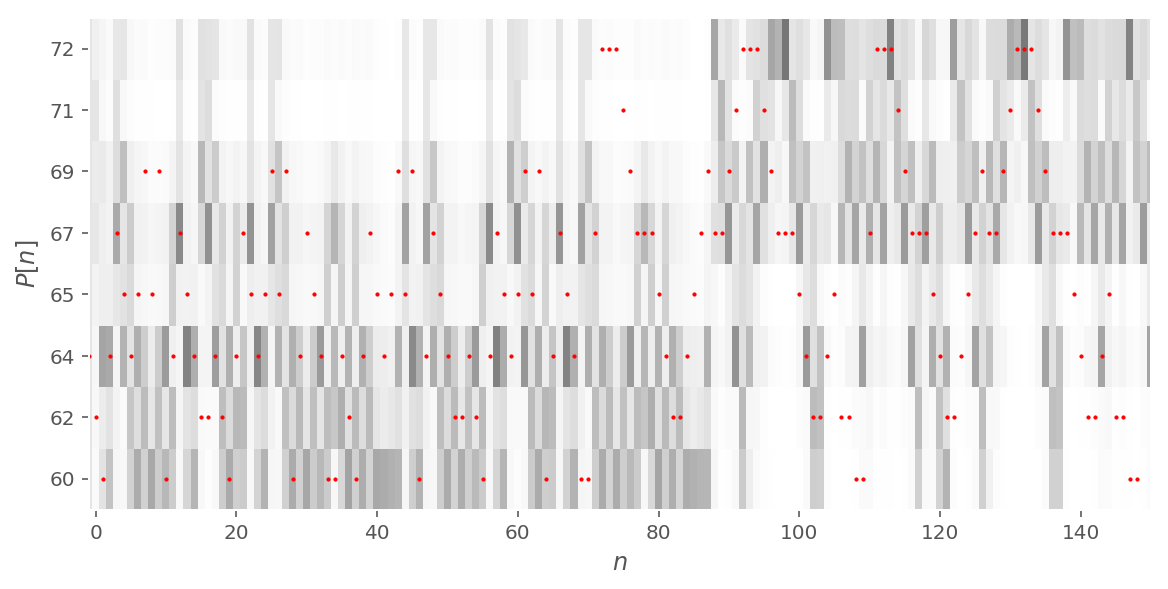

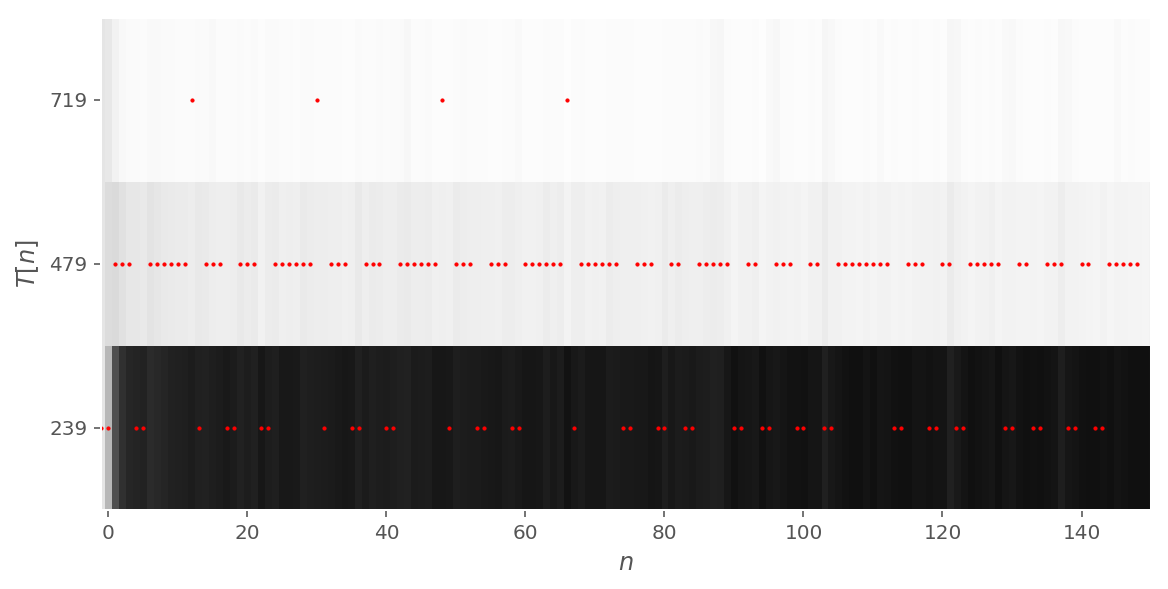

Predicting song 2...
Prediction performance: 
['loss', 'YT_loss', 'YP_loss', 'YT_acc', 'YP_acc']:
[2.2609877586364746, 0.7091221213340759, 1.5518656969070435, 0.75, 0.42424243688583374]


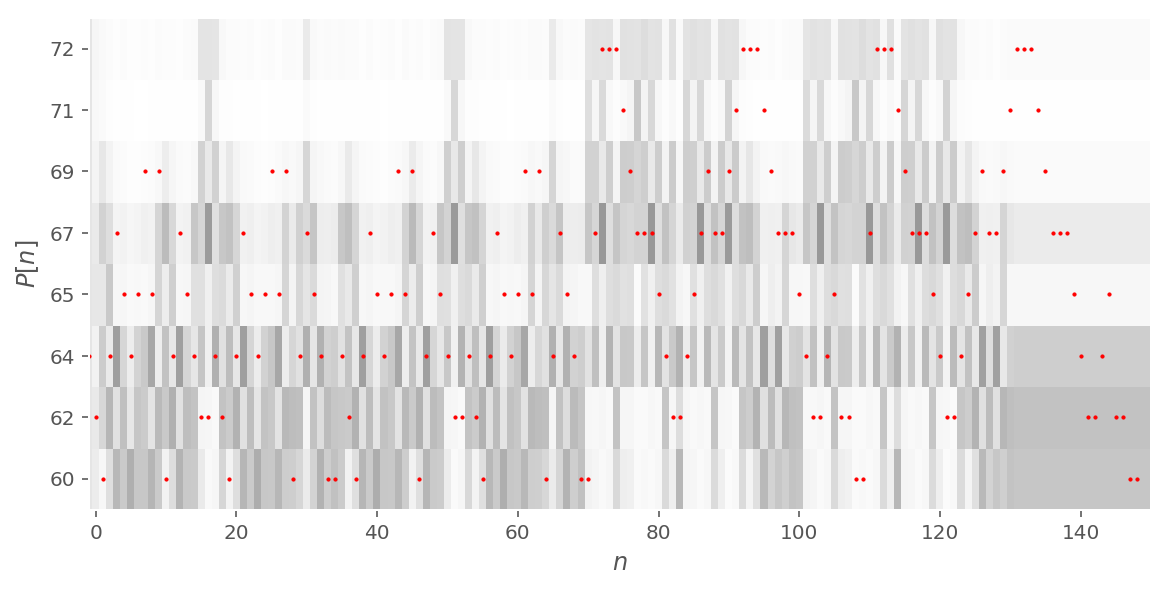

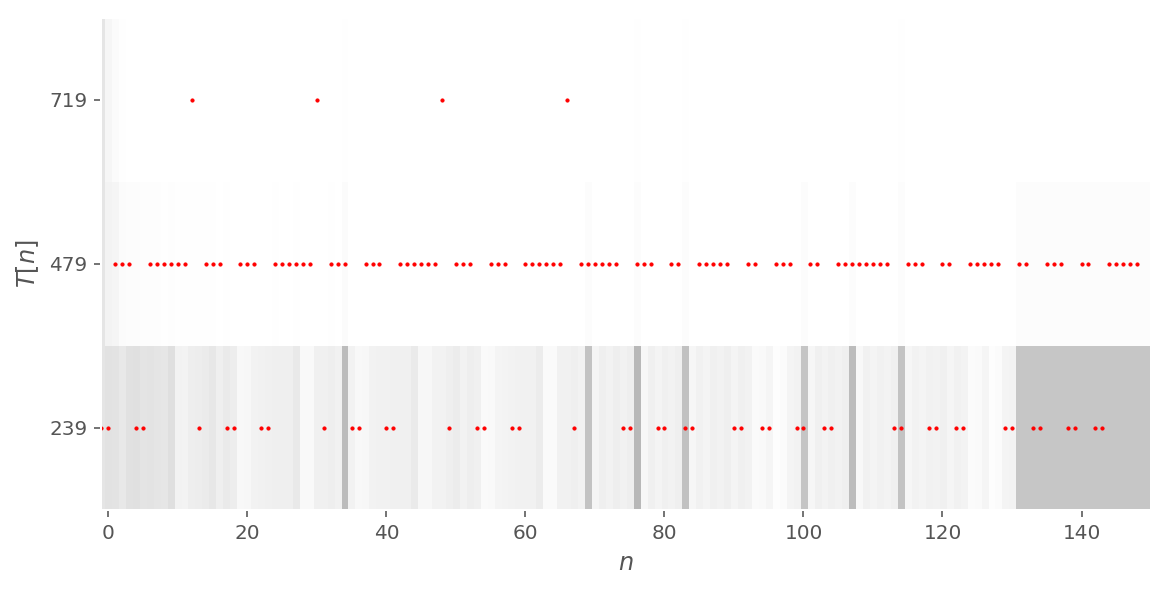

Predicting song 3...
Prediction performance: 
['loss', 'YT_loss', 'YP_loss', 'YT_acc', 'YP_acc']:
[3.104799747467041, 1.1298637390136719, 1.9749361276626587, 0.5151515603065491, 0.27272728085517883]


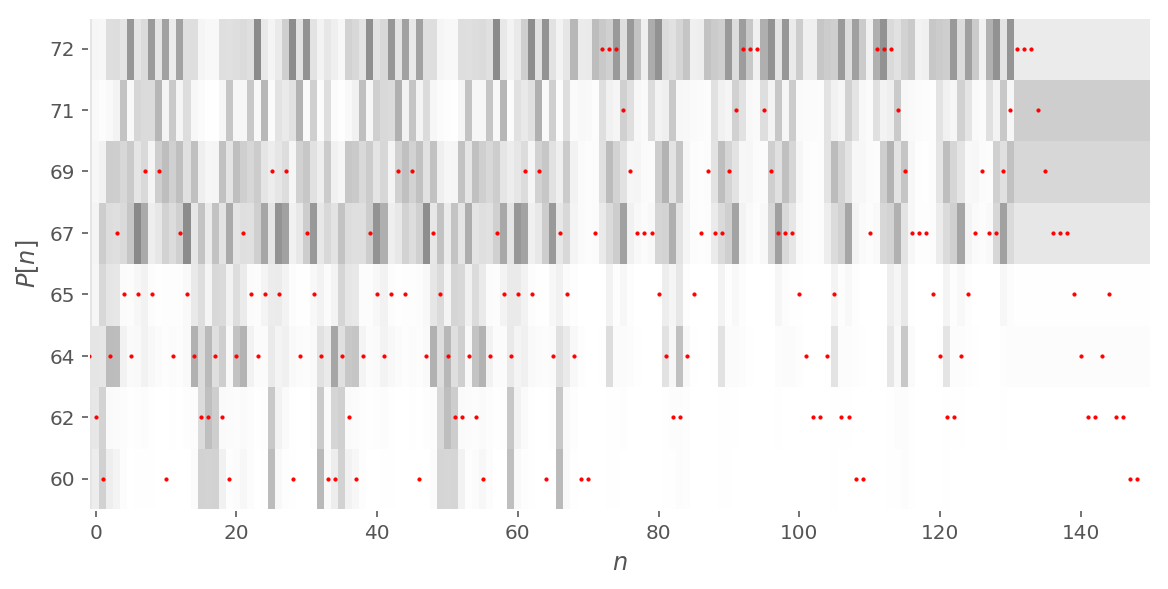

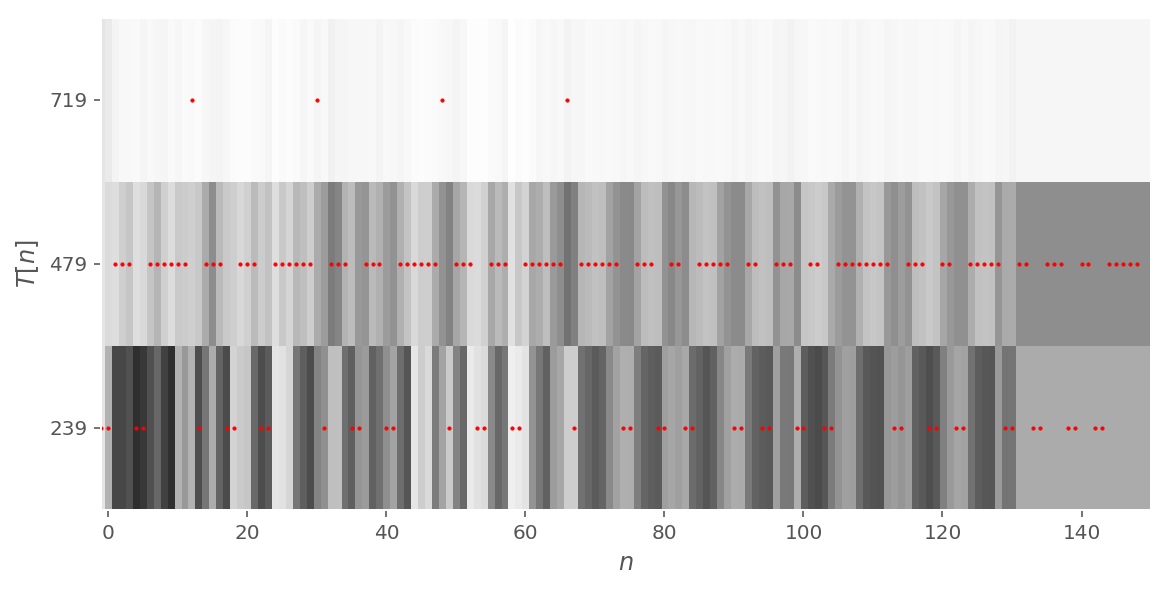

Predicting song 4...
Prediction performance: 
['loss', 'YT_loss', 'YP_loss', 'YT_acc', 'YP_acc']:
[3.0054402351379395, 0.7997533082962036, 2.2056868076324463, 0.6679102778434753, 0.3432835638523102]


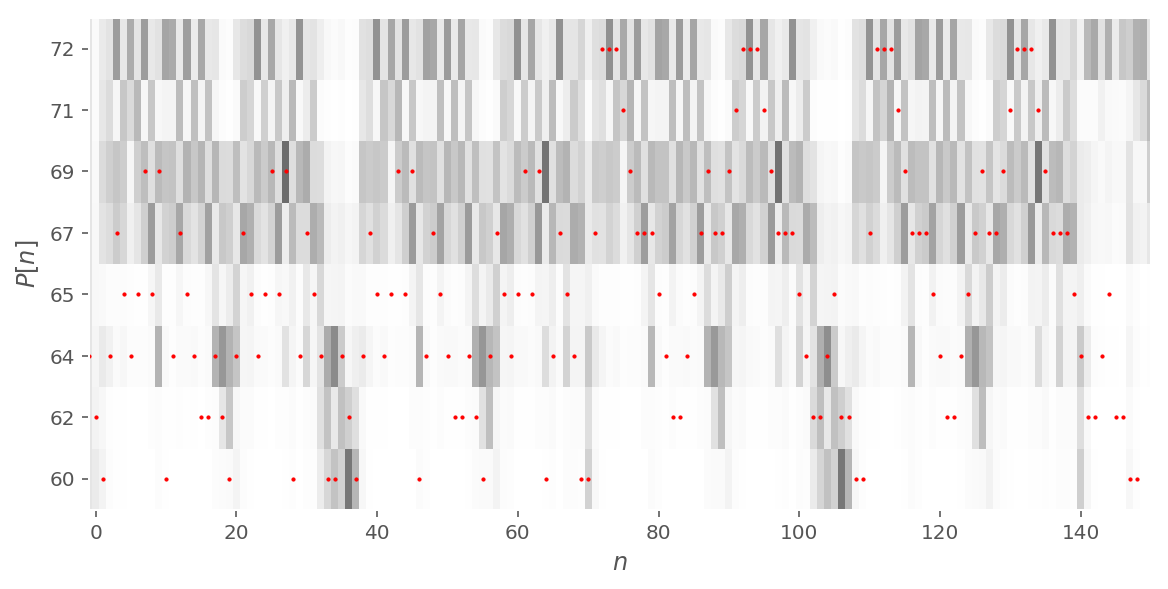

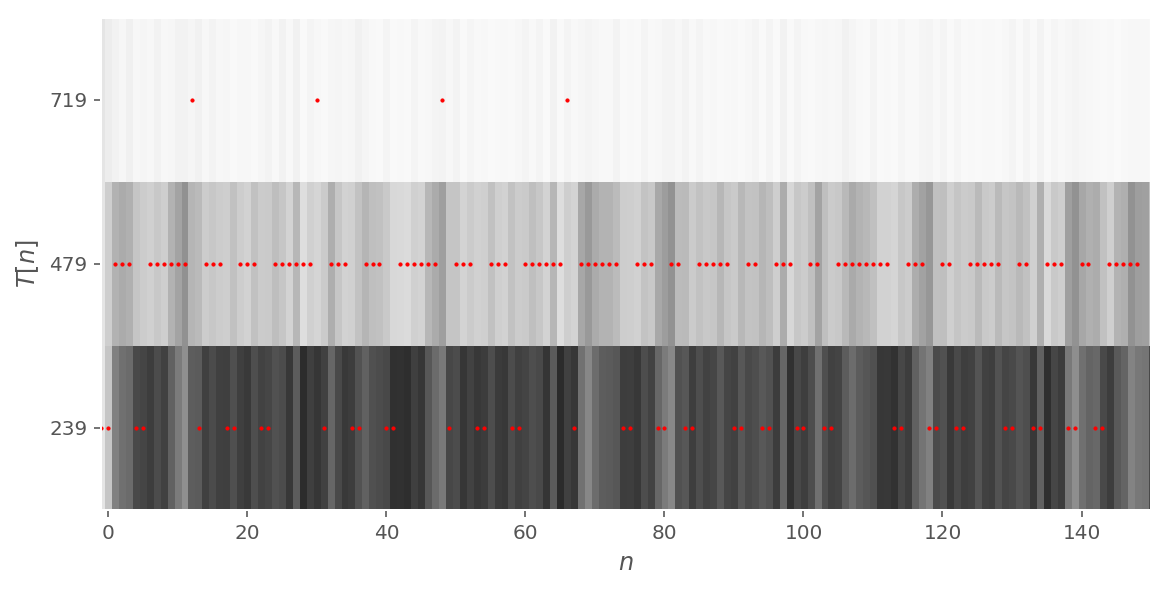

In [810]:
modelOutput(GRUmodel, GRUmodel_states, XP, XT, YP, YT, hidden_states = False)

**2.Visualize the hidden states**

As we can see at this [link](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/), there are two fundamental outputs when we define the `buildModel` function:
- `return_sequences` return the hidden state output for each input time step.
- `return_state` returns the hidden state output and cell state for the last input time step.

Moreover, as explained [here](https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/), for GRU we will use `return_sequences`. Therefore, since we activated `return_sequences`, we already have access to all the hidden units. However, we are applying a Dense layer on top of it. For this reason we add a shared model `model_state` that outputs the hidden states. (Added in the buildModel function defined above.) This is extremely practical because since this model share all the weights, there's no need to train it again, and we can apply the prediction function directly.

Let's see the states representation:

Predicting song 1...
Prediction performance: 
['loss', 'YT_loss', 'YP_loss', 'YT_acc', 'YP_acc']:
[1.9280089139938354, 0.36405149102211, 1.5639574527740479, 0.9008623361587524, 0.3448275923728943]
(380, 128)


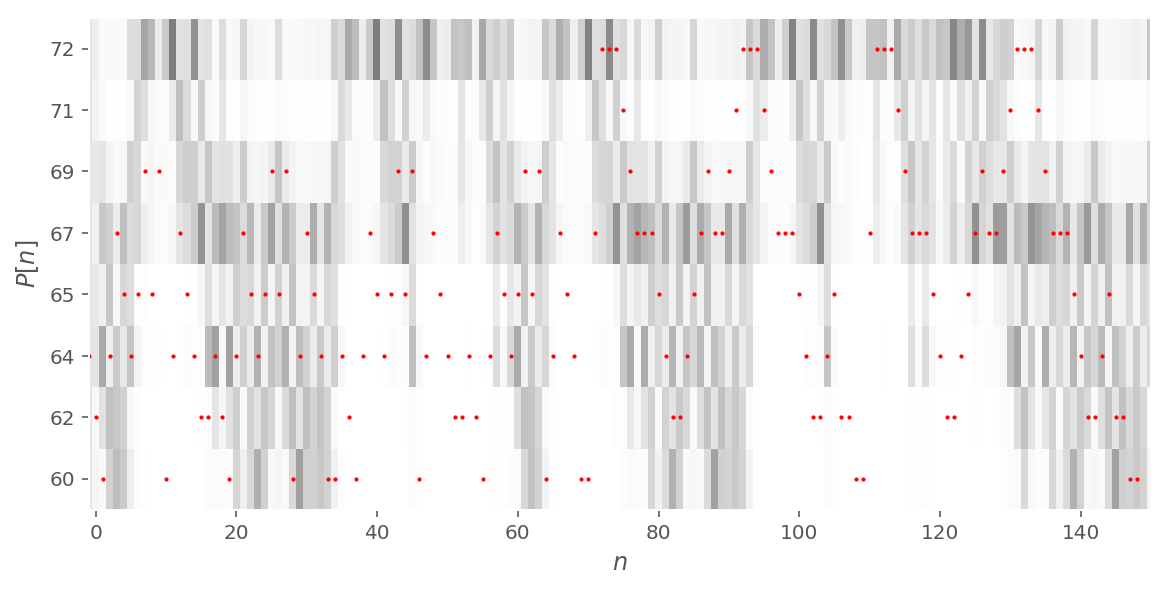

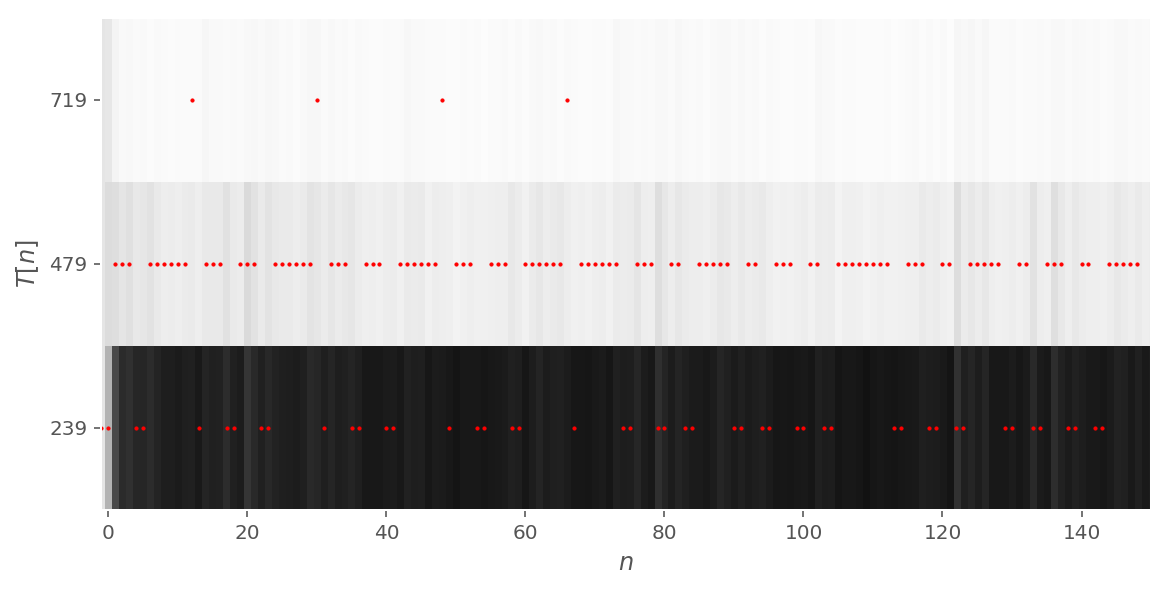

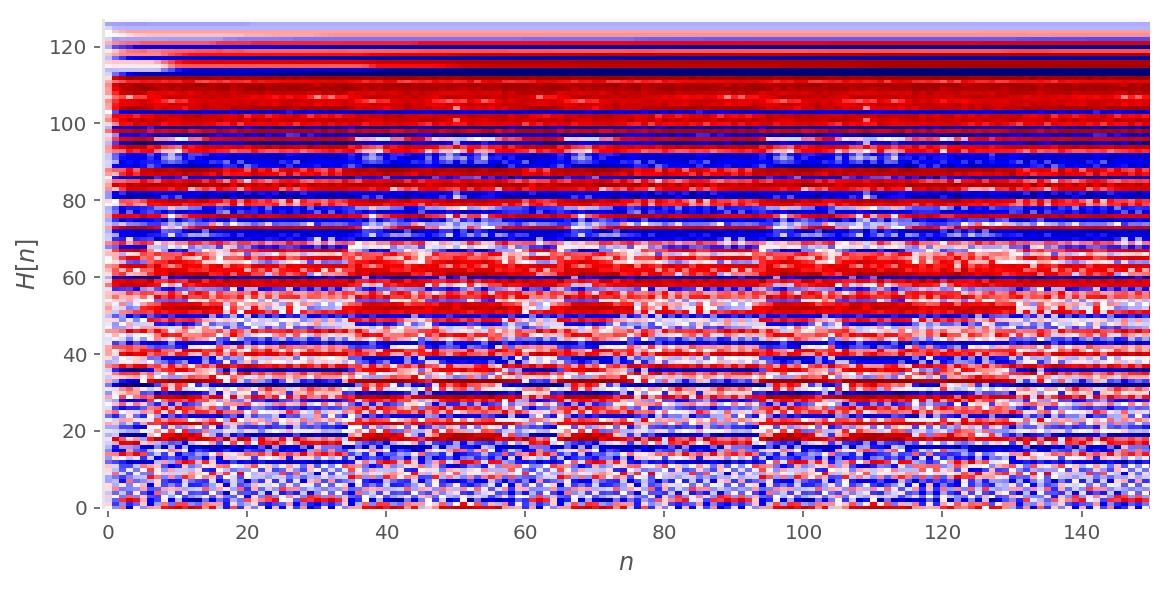

Predicting song 2...
Prediction performance: 
['loss', 'YT_loss', 'YP_loss', 'YT_acc', 'YP_acc']:
[2.5497498512268066, 0.698275089263916, 1.851474642753601, 0.8176100850105286, 0.35849055647850037]
(380, 128)


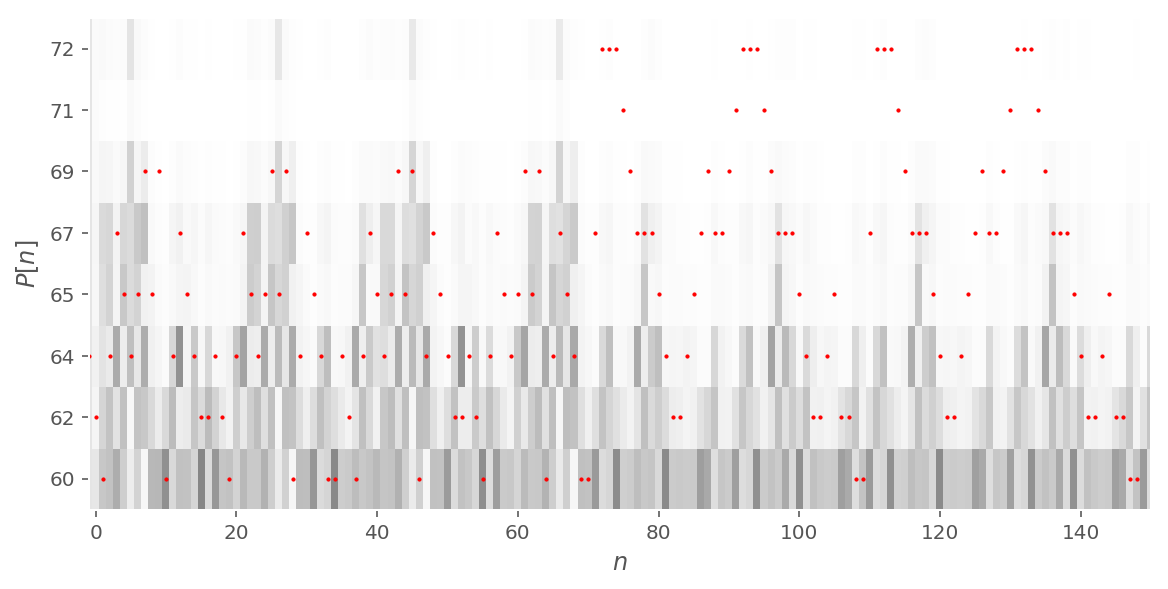

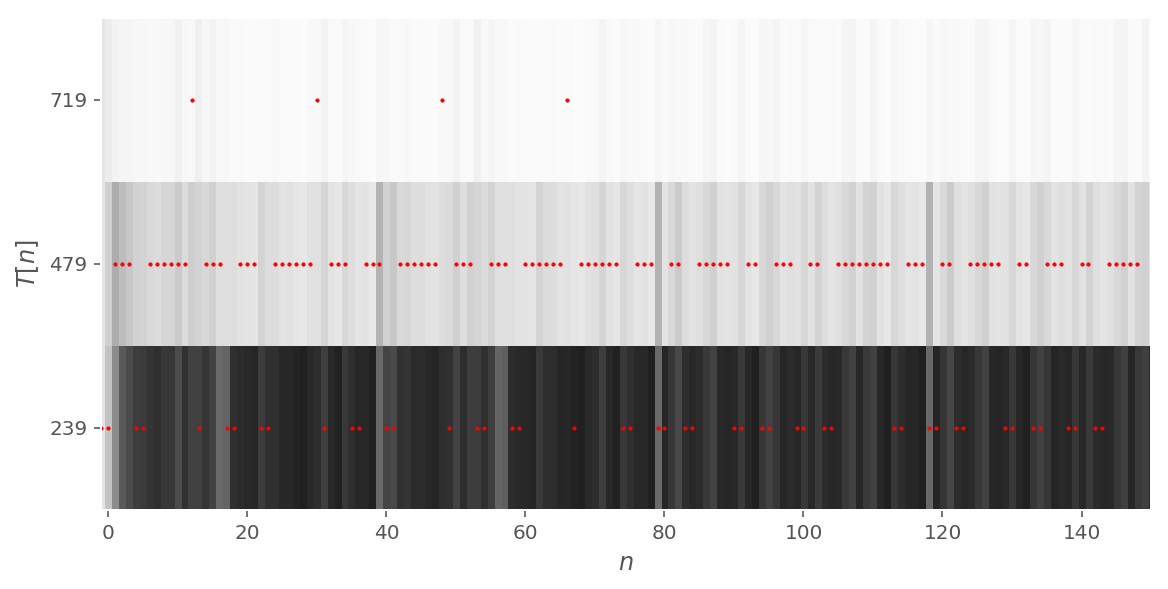

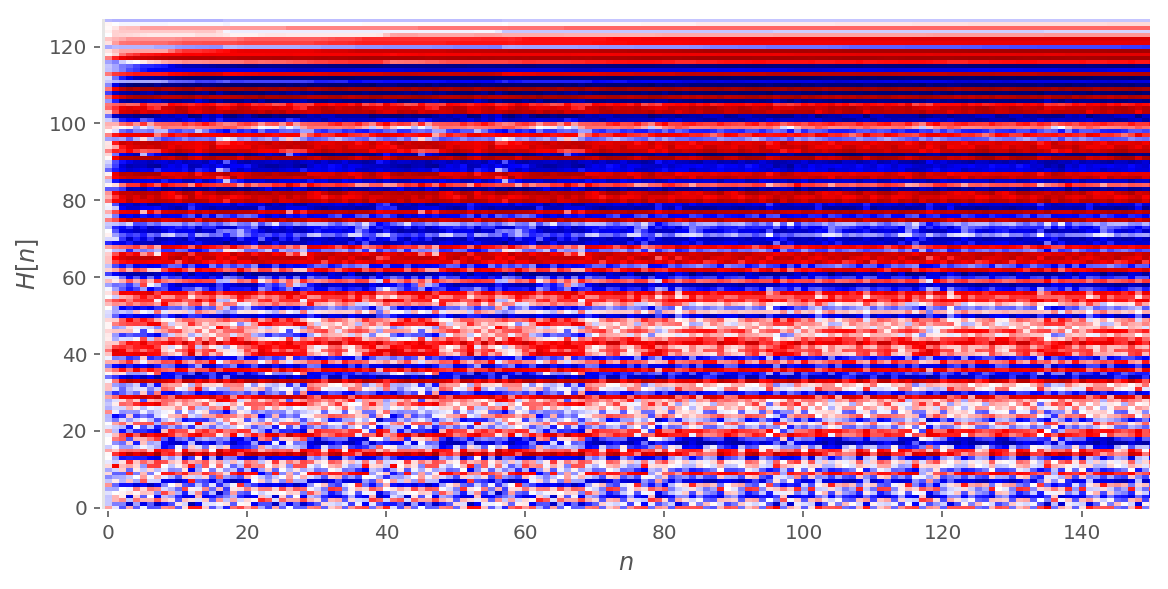

Predicting song 3...
Prediction performance: 
['loss', 'YT_loss', 'YP_loss', 'YT_acc', 'YP_acc']:
[3.0193593502044678, 0.8618327975273132, 2.1575264930725098, 0.7000001668930054, 0.3214286267757416]
(380, 128)


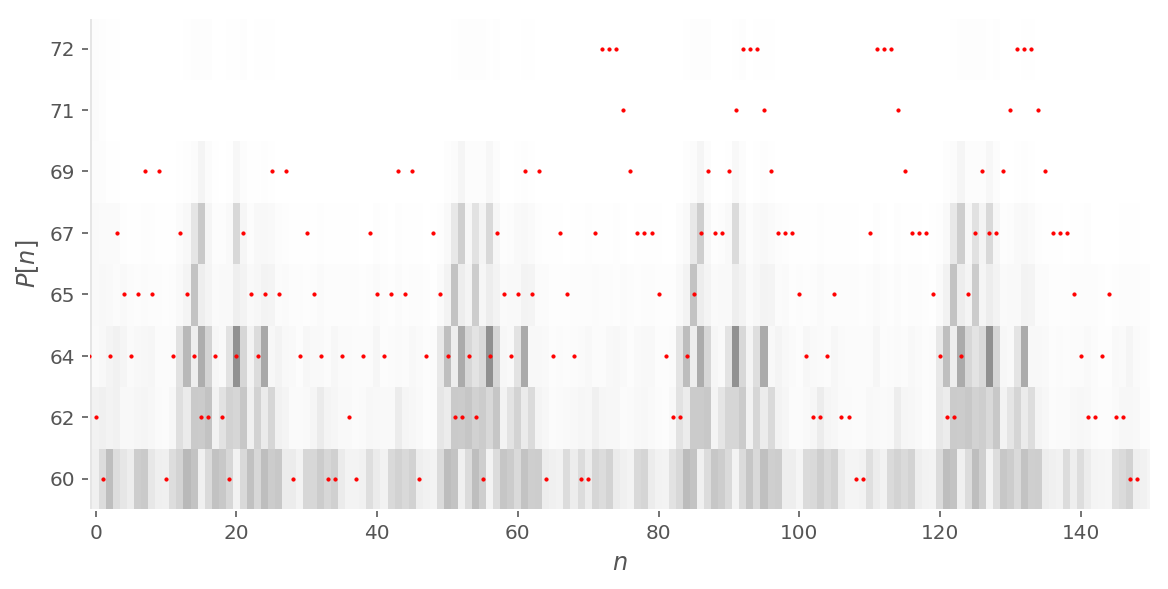

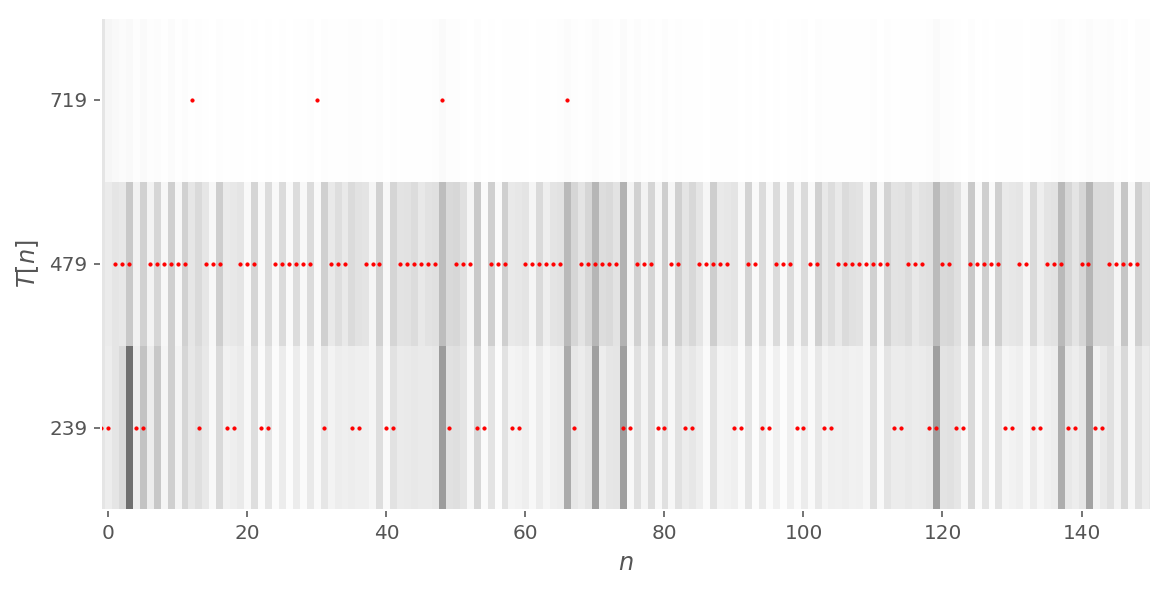

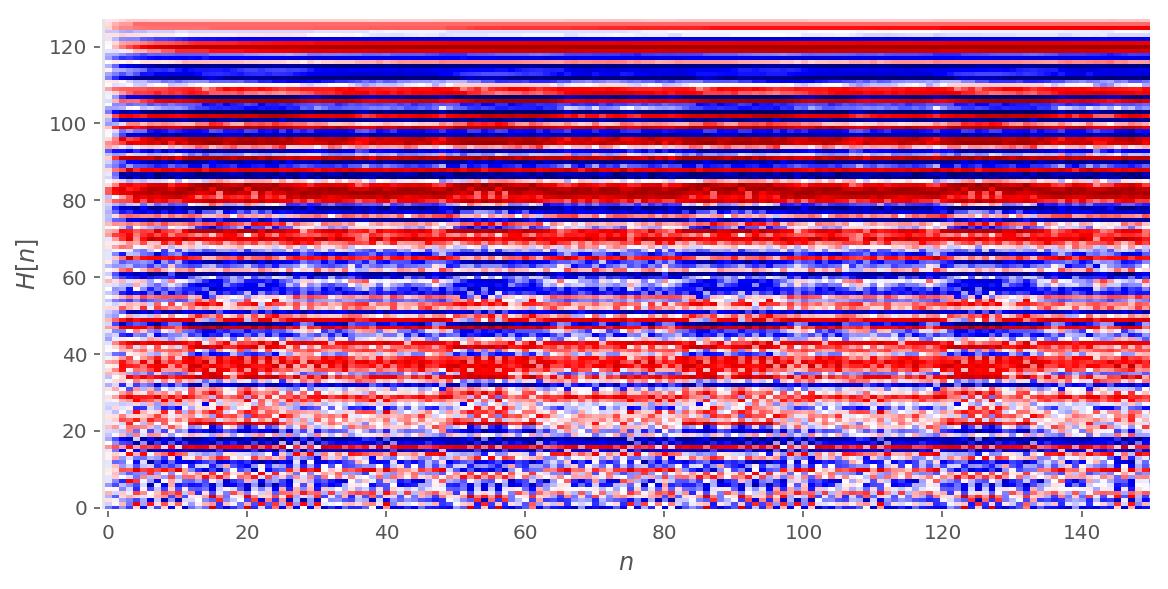

Predicting song 4...
Prediction performance: 
['loss', 'YT_loss', 'YP_loss', 'YT_acc', 'YP_acc']:
[2.000016212463379, 0.34159719944000244, 1.6584190130233765, 0.9173553586006165, 0.42975202202796936]
(380, 128)


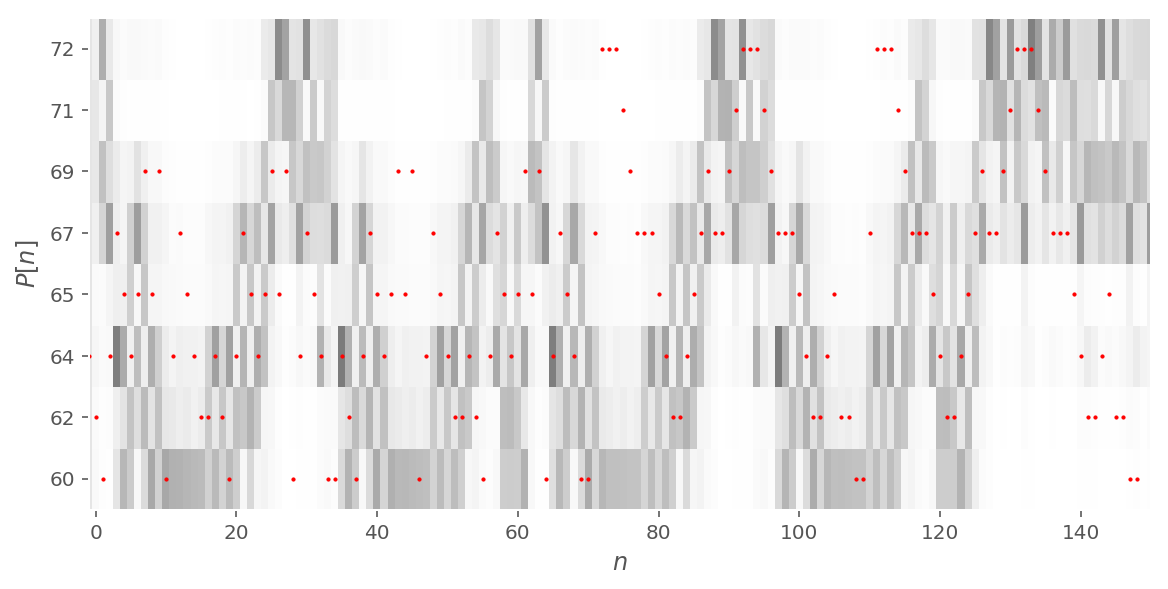

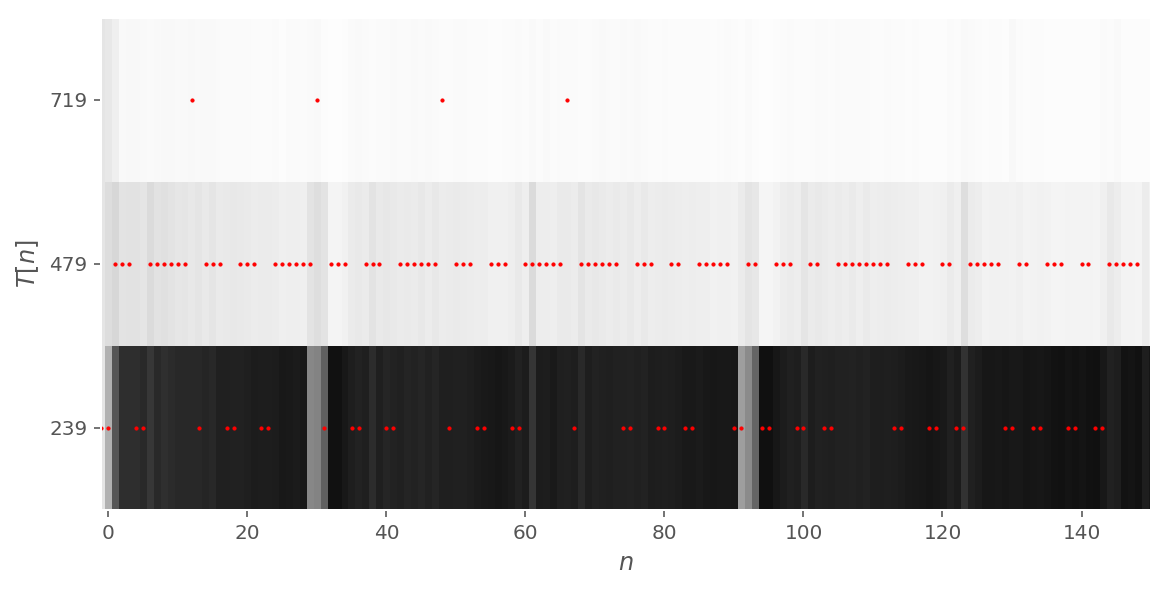

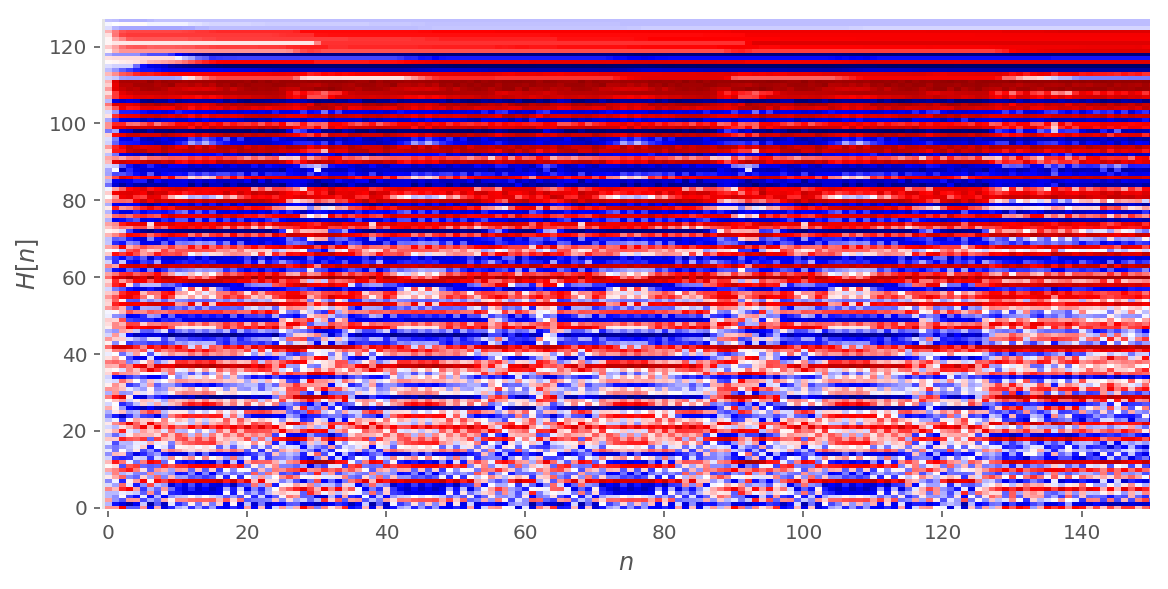

In [817]:
modelOutput(GRUmodel, GRUmodel_states, XP, XT, YP, YT, hidden_states = True)

**3.Visualize Hidden State Distribution**

**Important**: In this exercise we pretend to analyse how the states change per *timestep*, and on *every song*, for the *two models*. 

Therefore, we compute the changes between two consecutive timesteps for a entire song, and average over all calculated timesteps.

We do this process for every song. In the end, we average the `absolute change activation` for every song.

In [946]:
def getActiveStates(H, activeidxes):
    '''
    Function that return the states only for 
    not masked inputs
    '''
    activeH = []
    for idx, hidden_prediction in enumerate(H):
        activeH.append(hidden_prediction[activeidxes[idx],:])
    return np.asarray(activeH)

def getAverageChange(H):
    '''
    Function to compute the absolute average change
    The function calculates, for each song and for each unit, the changes for 
    every time step, and averages it over all songs.
    '''
    hidden_units = H[0].shape[1]
    avgUnit = []
    for song in range(H.shape[0]):
        avgUnit_perSong = []
        for hidden_unit in range(hidden_units):
            states = H[song][:-1,hidden_unit] # step t-1
            states_shifted = H[song][1:, hidden_unit] # step t

            avg_per_timeStep = np.asarray(abs(states - states_shifted)) # change for every timestep
            avgUnit_perSong.append(np.mean(avg_per_timeStep)) # changes' average
        avgUnit.append(avgUnit_perSong)

    # average over songs
    avgUnit = np.asarray(avgUnit).mean(0)
    
    return avgUnit

def plotHiddenChanges(x, y, labels):
    '''
    Plot histogram for hidden states distribution
    '''
    plt.figure(figsize=(20,7))
    plt.hist(x, 50, alpha=0.5, label=labels[0])
    plt.hist(y, 50, alpha=0.5, label=labels[1])
    plt.legend(loc='upper right')
    plt.show()

def hiddenDistribution(model_states, XP, XT):
    '''
    Function to get the average absolute change
    in the hidden states.
    '''
    # get indeces for not masked inputs
    activeidxes = []
    for song in range(XP.shape[0]):
        activeidxes.append(np.where(np.sum(XP[song], axis=1)>0.)[0])
   
    # get hidden States
    H = model_states.predict(x = [XT, XP], batch_size=50)
    
    # filter active indices
    H = getActiveStates(H, activeidxes)
    
    # average over unit and song
    avgChange = getAverageChange(H)
    
    return avgChange

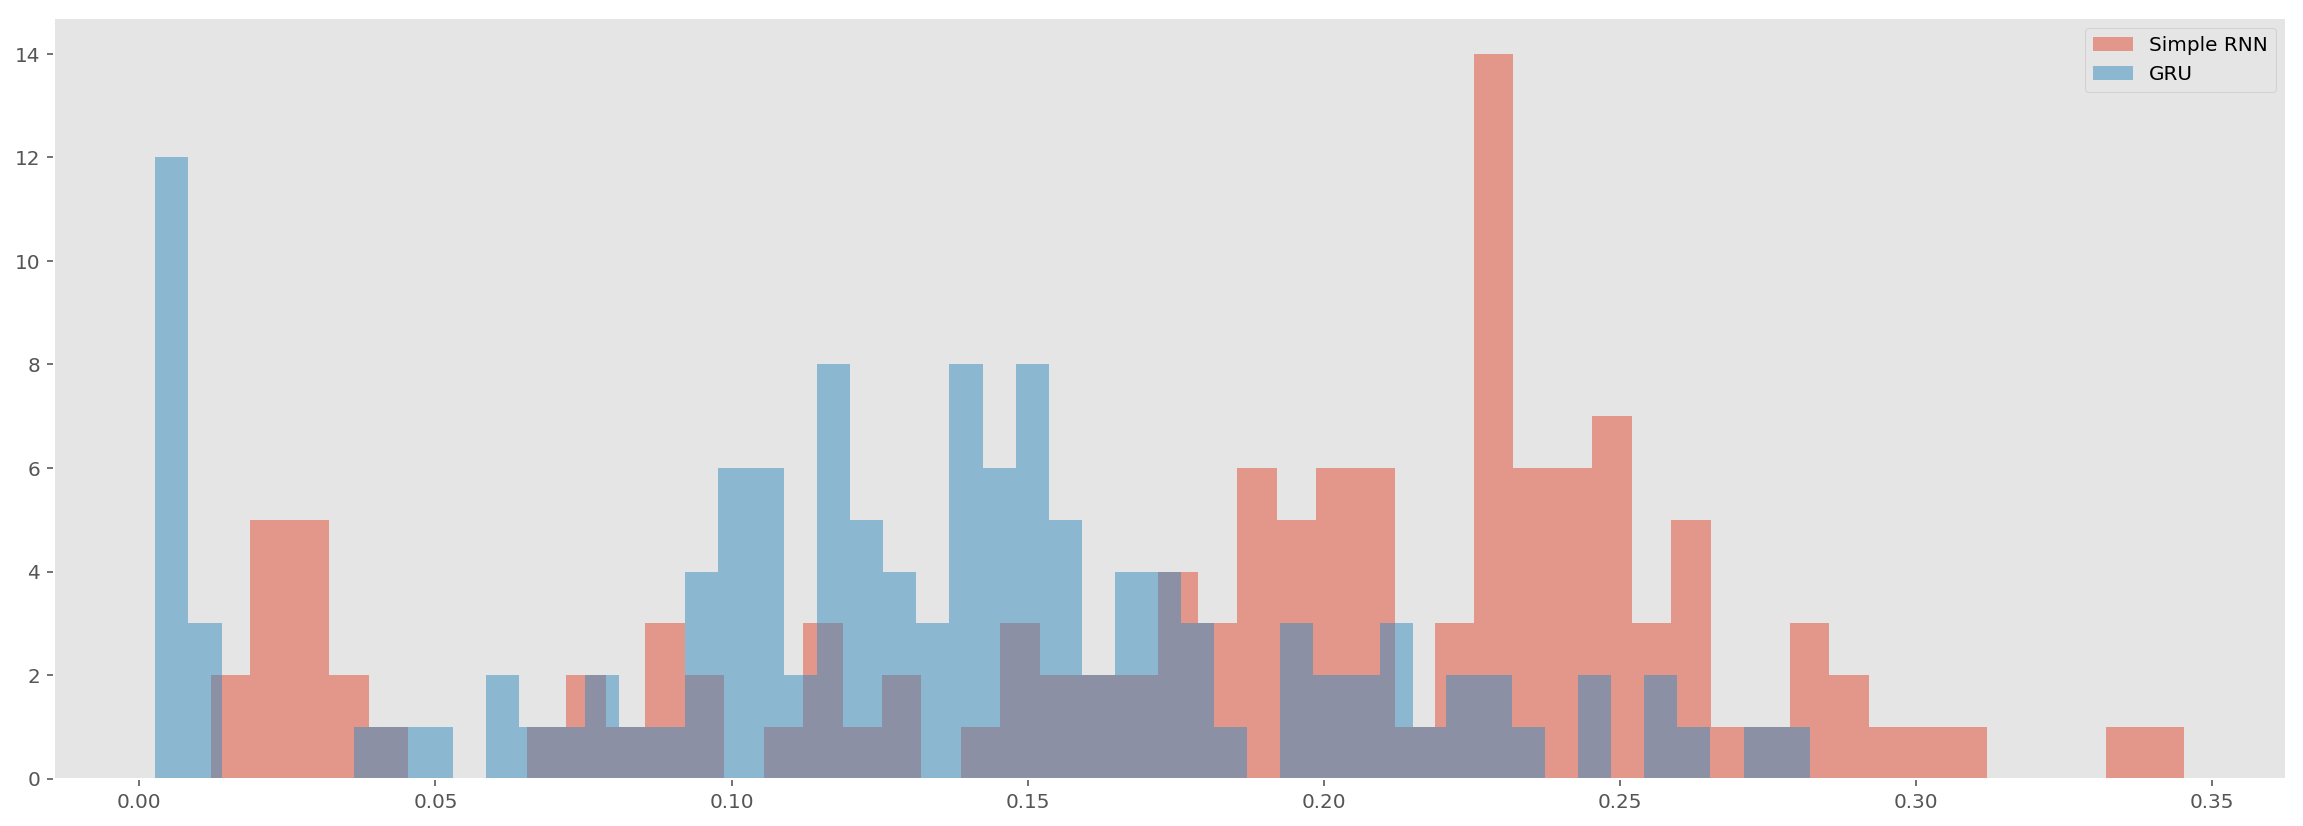

In [947]:
hiddenChangesRNN = hiddenDistribution(RNNmodel_states, XP, XT)
hiddenChangesGRU = hiddenDistribution(GRUmodel_states, XP, XT)
plotHiddenChanges(hiddenChangesRNN, hiddenChangesGRU, labels = ['Simple RNN', 'GRU'])

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: From the figure above, we observe that the state changes in the GRU model are slower than the ones for the simple RNN model. Since the GRU model keeps longer memories (long-term memories), its states are more dependent on previous ones, which gives it less freedoom to change its states more abruptly.

## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). You might have to use the "Trust notebook" button (in the top right corner) to see the players. This currently only works in jupyter notebook (not jupyter lab). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

In [692]:
def generateMelodie(model, dictionary, randomInit, temperature, song_length):
    '''
    Function to generate a melodie
    :param model: previously trained model
    :param dictionary: dataset of songs
    :param randomInit: boolean that defines randomnsess of first note
    :param temperature: param to use when performing sampling
    :param song_length: lenght of the songs in the dataset
    :Return XT, XP: array with one hot encoded songs
    :Return xT_midi, xP_midi: array with ineteger representation to write midi file
    '''
    XP, XT, xP_midi, xT_midi = getNote(dictionary, randomInit)
    XP = np.reshape(XP, (1, 1, len(P_dictFilt)))
    XT = np.reshape(XT, (1, 1, len(T_dictFilt)))
    XP, XT = paddingSong(XP, XT, song_length)

    for idx in range(song_length - 1):
        # 1. probability vectors
        next_T, next_P = model.predict(x = [XT, XP], batch_size = 1)
        # 2. integer representation
        next_T = sample(next_T[0][-1],temperature)
        next_P = sample(next_P[0][-1], temperature)
        xT_midi.append(next_T); xP_midi.append(next_P) # append midi values
        # 3. one hot representation
        next_T = np_utils.to_categorical(next_T,len(T_dictFilt)) 
        next_P = np_utils.to_categorical(next_P, len(P_dictFilt))
        try:
            XT[0][idx+1] = next_T 
            XP[0][idx+1] = next_P
        except:
            # got to last position, append last prediction
            XT = np.append(XT, [[next_T]], axis = 1)
            XP = np.append(XP, [[next_P]], axis = 1)
            
    return XT, XP, xT_midi, xP_midi

def getNote(dictionary, random = True):
    '''
    Function to build initial note
    randomly sampled from one melodie
    Returns first note both in onehot format
    and integer format
    '''
    if random:
        label = np.random.choice(list(dictionary.keys()))
        note_P = dictionary[label]['P'][0]
        note_T = dictionary[label]['T'][0]
    else:
        # get most common init note
        init_P = []; init_T = [];
        for label in list(dictionary.keys()):
            init_P.append(dictionary[label]['P'][0])
            init_T.append(dictionary[label]['T'][0])
        note_P = most_common(init_P)
        note_T = most_common(init_T)
        
    # save integer format for midi_file    
    note_P_midi = np.where(np.asarray(note_P)==1)[0].tolist() 
    note_T_midi = np.where(np.asarray(note_T)==1)[0].tolist()
    
    return note_P, note_T, note_P_midi, note_T_midi

def paddingSong(XP, XT, song_length):
    '''
    Function to perform padding on "in generation" song
    '''
    XP_padded = pad_sequences(XP, maxlen=song_length-1, padding='post' ,truncating='post', value=0.0)
    XT_padded = pad_sequences(XT, maxlen=song_length-1, padding='post' ,truncating='post', value=0.0)
    
    return XP_padded, XT_padded

def most_common(lst):
    '''
    Function to get most common init value
    To check most common, must convert one hot to integer format
    Retrieve the most common element in one hot representation again
    '''
    size = len(lst[0]) # save one hot size
    lst = [np.where(r==1)[0][0] for r in lst] 

    return np_utils.to_categorical(max(set(lst), key=lst.count), size)

**1. Generate simple song and create midi file:**

In [660]:
XT, XP, xT_midi, xP_midi = generateMelodie(GRUmodel, dataset_padded, False, 1, song_length)

In [662]:
writeMIDI(xP_midi, xT_midi, dictionariesFilt, 'test.mid')

In [663]:
music21.midi.translate.midiFilePathToStream('/test.mid').show('midi')

**2. Trying out the effect of changing the temperature:**

By setting random to `False`, we always start with the same note, which allows to make a more fair comparison.

In [672]:
temperatures = [0.5, 1, 1.5]
counter_per_temperature = []
for temperature in temperatures:
    XT, XP, xT_midi, xP_midi = generateMelodie(GRUmodel, dataset_padded, False, 1, song_length)
    counter_per_temperature.append((Counter(xT_midi), Counter(xP_midi)))
    file_name = 'generated/temperatures/test_temperature'+str(temperature).replace('.','_')+'.mid'
    writeMIDI(xP_midi, xT_midi, dictionariesFilt, file_name)
    print('Generated melodie for temperature: - ', temperature)
    music21.midi.translate.midiFilePathToStream(file_name).show('midi')

Generated melodie for temperature: -  0.5


Generated melodie for temperature: -  1


Generated melodie for temperature: -  1.5


A comment on the differences is done on the question at the very bottom.

**3. Generating 32 melodies with both the RNN and GRU models**

In [699]:
N_TRACKS = 32

In [700]:
def generateAlbum(mode ,model, temperatures, song_length):
    '''
    Function to generate a set of ntracks for a given model
    Temperature is given as an array of valid values to 
    choose from randomly.
    '''
    for track_i in range(N_TRACKS):
        # 1. select temperature randomly:
        temperature = random.choice(temperatures)
        # 2. generate model
        XT, XP, xT_midi, xP_midi = generateMelodie(model, dataset_padded, True, temperature, song_length)
        # 3. write midi file
        track_name = 'generated/'+mode+'/track_'+str(track_i)+'.mid'
        writeMIDI(xP_midi, xT_midi, dictionariesFilt, track_name)

Simple RNN:

In [701]:
generateAlbum('SimpleRNN', RNNmodel, temperatures, song_length)

GRU:

In [702]:
generateAlbum('GRU', GRUmodel, temperatures, song_length)

**4. Listening to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model).**

In [703]:
def playMusic(mode, tracks):
    '''
    Funtion to play selected tracks in either Simple RNN
    or GRU mode
    '''
    for track in tracks:
        track_name = 'generated/'+mode+'/track_'+str(track)+'.mid'
        print('Get ready! Playing track {} in {} mode'.format(track, mode))
        music21.midi.translate.midiFilePathToStream(track_name).show('midi')

In [704]:
album_tracks = np.arange(N_TRACKS)

# Simple RNN mode
playMusic('SimpleRNN', [random.choice(album_tracks), random.choice(album_tracks)])

# GRU mode
playMusic('GRU', [random.choice(album_tracks), random.choice(album_tracks)])

Get ready! Playing track 22 in SimpleRNN mode


Get ready! Playing track 19 in SimpleRNN mode


Get ready! Playing track 1 in GRU mode


Get ready! Playing track 15 in GRU mode


In [951]:
album_tracks = np.arange(N_TRACKS)

# Simple RNN mode
playMusic('SimpleRNN', [random.choice(album_tracks), random.choice(album_tracks)])

# GRU mode
playMusic('GRU', [random.choice(album_tracks), random.choice(album_tracks)])

Get ready! Playing track 17 in SimpleRNN mode


Get ready! Playing track 8 in SimpleRNN mode


Get ready! Playing track 21 in GRU mode


Get ready! Playing track 5 in GRU mode


**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: The temperature parameter for sampling allows us to define how "conservative" we want our model to be. In other words, depending on the temperature selected, the model could be more conservative or less conservative when predicting the next note. For a lower number, we observe a more conservative behaviour on the melodie, which could be even considered as more boring. On the other hand, as we increase the temperature, we get more diversity, at the risk of certain unnatural note transitions.

In fact, let's see the counters distributions for the tested temperatures:

In [678]:
for idx, counter in enumerate(counter_per_temperature):
    print('\nTemperature - ', temperatures[idx])
    print('Temperature counts: ', counter[0])
    print('Pitch counts: ', counter[1])


Temperature -  0.5
Temperature counts:  Counter({7: 366, 11: 12, 12: 3})
Pitch counts:  Counter({28: 77, 23: 65, 30: 37, 32: 36, 27: 29, 25: 28, 20: 23, 21: 20, 16: 17, 33: 17, 35: 16, 18: 7, 15: 4, 26: 2, 11: 1, 22: 1, 37: 1})

Temperature -  1
Temperature counts:  Counter({7: 321, 11: 49, 12: 9, 14: 2})
Pitch counts:  Counter({23: 70, 20: 70, 21: 46, 18: 45, 16: 38, 25: 31, 28: 31, 27: 22, 30: 8, 15: 6, 26: 3, 11: 3, 32: 3, 13: 1, 19: 1, 22: 1, 31: 1, 33: 1})

Temperature -  1.5
Temperature counts:  Counter({7: 304, 12: 37, 11: 34, 14: 4, 4: 2})
Pitch counts:  Counter({23: 75, 20: 47, 28: 45, 25: 38, 16: 37, 18: 31, 27: 27, 21: 26, 30: 16, 11: 11, 13: 8, 32: 6, 15: 5, 9: 4, 33: 3, 4: 1, 8: 1})


Indeed, as expected, we observe more diverse distributions as we increase the temperature. For example, if we look at the durations, for a **temperature of 0.5 we have 96%(366/381) of the notes with the same duration**, where as for a **temperature of 1.5, the same note duration represents now 79%(304/381) of the total notes**.

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: 

